In [39]:
### Imports ###

from qutip import *
import pennylane as qml
import numpy as np
import numpy.ma as ma
import random
import math
import json
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import timeit
import sympy
import itertools
from datetime import datetime
from NC_LUE import NC

# For defining initial objects
import qutipHam
import total_sys_GGMMs as ggmm
import mod_initstates as init

# For scrambling Hamiltonians
import matplotlib.pyplot as plt
import mod_timeevol as te
import mod_score as sc

# For minimization
import time
import scipy as sci
import scipy.optimize as optimize


# For saving data
import csv, sys, json
import os
from datetime import datetime

# Plotting parameters 
rcParams['figure.figsize'] = 8,8
u = 25
y_ub = 0.4
y_lb = -10**-2
ms = 30
opacity = 0.03
lineColor = 'black'
s1rob_args = {'s': ms, 'color': 'purple', 'label': r'$\langle S_{\Pi, rob} \rangle_L$', 'alpha': 1}
s1Mrob_args = {'s': ms, 'color': 'purple', 'label': r'$\langle S_{\Pi, rob} \rangle_L$', 'alpha': 1}
s2rob_args = {'s': ms, 'color': 'orchid', 'label': '$S_{\Pi, rob}$', 'alpha': opacity}
s2Mrob_args = {'s': ms, 'color': 'darkviolet', 'label': '$S_{TPS, rob}$', 'alpha': 1}

s1pred_args = {'s': ms, 'color': 'steelblue', 'label': r'$\langle S_{\Pi, pred} \rangle_L$', 'alpha': 1}
s1Mpred_args = {'s': ms, 'color': 'steelblue', 'label': r'$\langle S_{\Pi, pred} \rangle_L$', 'alpha': 1}
s2pred_args = {'s': ms, 'color': 'lightsteelblue', 'label': '$S_{\Pi, pred}$', 'alpha': opacity}
s2Mpred_args = {'s': ms, 'color': 'dodgerblue', 'label': '$S_{TPS, pred}$', 'alpha': 1}

ze_args_rob = {'color': lineColor, 'linestyle': '--'}
ze_args_pred = {'color': lineColor, 'linestyle': '--'}

l1M_args = {'s': ms, 'color': 'lightskyblue', 'label': '$1$-local', 'alpha': 1}
l2M_args = {'s': ms, 'color': 'navy', 'label': '$2$-local', 'alpha': 1}
l3M_args = {'s': ms, 'color': 'thistle', 'label': '$3$-local', 'alpha': 1}
l4M_args = {'s': ms, 'color': 'darkviolet', 'label': '$4$-local', 'alpha': 1}

In [40]:
### Parameters ###

num_env_qbs = 1
n = num_env_qbs+1  # we have one qubit as our system, rest of qubits as environment
dim_sys = 2
dim_env = 2**num_env_qbs
dim_tot = 2**(n)

# coupling constants for Hamiltonian
cc = 1
cx = cy = cz = 1
LUorU = 'y' 

# ising, spin bath, heisenberg
# initial_hams = [qutipHam.H_ising(n, cc), qutipHam.H_sb(n, cc), qutipHam.H_heis(n, cx, cy, cz)]
initial_hams = [qutipHam.H_ising(n, cc), qutipHam.H_sb(n, cc), qutipHam.H_cnot(n)]
# ham_names = [r'$H_{is}$', r'$H_{sb}$', r'$H_{heis}$']
ham_names = [r'$H_{is}$', r'$H_{sb}$', r'$H_{CNOT}$' ]

ham_num = 2
initial_ham = initial_hams[ham_num]
# print(f'initial ham = {initial_ham}')
ham_name = ham_names[ham_num]
tensor_initial_states, initial_states = init.init_states(num_env_qbs)
# print(f'Tensor Initial States: {initial_states[0]}')
# print(f'Initial States: {initial_states[1]}')

# # Define Ham_names for data saving
# ham_names_for_data = ['Ising', '']


# even superposition environment ready state
sysRho = np.zeros((2, 2))
sysRho[0][0] = 1   # specifying pure state where first entry is one
sysRho = Qobj(sysRho)

#random dm
# randRho = rand_dm(2**n, dims = [[2]*n]*2)
randRho = rand_dm(2**n)
randRho.dims = [[2]*n]*2 # 2*n input space (n qubits of dim 2), 2*n output space (n qubits of dim 2); 
randRho = [randRho]*2

envRho = Qobj(np.ones(shape=(2**(n-1), 2**(n-1))), dims = [[2]*(n-1)]*2)/2**(n-1)
eSup = tensor(sysRho, envRho)
eSup = [eSup, eSup]

# Constructing GGMMs (Generalized Gel-Mann Matrices)
selfGGMMs = ggmm.constructSelfGGMMs(n, 0)
allGGMMs = ggmm.constructTotalGGMMs(n)

if LUorU == 'n':
    # only self-hamiltonians used if local unitary operators considered
    totGGMMs = selfGGMMs
    el = 3
else:
    # for global unitaries, consider allGGMMs
    totGGMMs = allGGMMs
    el = dim_tot**2-1

initial_thetas = [0]*len(totGGMMs)

TypeError: H_ising() missing 1 required positional argument: 'c'

In [ ]:
### Function definitions ###

def haar_SU(n):
    '''
    Starts with haar unitary from qutip, then removes phase so determinant
    of resulting unitary is 1.
    '''
    N = 2**n
    rU = rand_unitary_haar(N, [[2]*n, [2]*n])
    return rU/(np.linalg.det(rU.full())**(1/N))

def HSIP(matrix1, matrix2, nVar):
    '''
    Hilbert Shmidt inner product for Hermitian matrices only!
    '''
    return ((matrix1.dag()*matrix2).tr())/2**nVar

def coeffGGMM(rho, GGMMs, nVar):
    '''
    Inputs:
    - rho: Hermitian matrix
    - n: Number of qubits composing the system
    - GGMMs: Generalized Gell-Mann Matrices
    Outputs:
    - coeff: Coefficients for vector representation (in GGMM basis) of M
    '''
    GGMM = GGMMs.copy()
    #GGMM.insert(0, tensor([qeye(2)]*n))
    coeff = [0]*len(GGMM)
    for i in range(len(GGMM)):
        coeff[i] = HSIP(rho, GGMM[i], nVar) 
    return coeff

def selfGGMMs(_n):
    lc = []
    _id = [qeye(2)]*_n
    _σ = [sigmax(), sigmay(), sigmaz()]
    _X = [sigmax()] + [qeye(2)]*(_n-1)
    _Y = [sigmay()] + [qeye(2)]*(_n-1)
    _Z = [sigmaz()] + [qeye(2)]*(_n-1)
    
    for i in range(3):
        _σi = _σ[i]
        for i in range(_n):
            term = _id.copy()
            term[i] = _σi
            lc.append(tensor(term))
    return lc

def selfCoeffs(_H, _GGMMs, _n):
    _selfGGMMs = selfGGMMs(_n)
    coeff = [0]*len(_selfGGMMs)
    for i in range(len(_selfGGMMs)):
        coeff[i] = HSIP(_H, _selfGGMMs[i], _n) 
    return coeff

def nonSelfCoeffs(_H, _GGMMs, _n):
    _nonSelfGGMMs = _GGMMs.copy()
    _selfGGMMs = selfGGMMs(_n)
    for x in _selfGGMMs:
        _nonSelfGGMMs.remove(x)
    coeff = [0]*len(_nonSelfGGMMs)
    for i in range(len(_nonSelfGGMMs)):
        coeff[i] = HSIP(_H, _nonSelfGGMMs[i], _n) 
    return coeff


def APHam(nVar, hamiltonian):
    # System permutations
    allHams = permuteHam(nVar, hamiltonian)
    # Non system permutations 
    nCombs = math.comb(nVar, 2) - nVar + 1
    for i in range(len(allHams)):
        for j in range(nCombs):
            permuteList = list(range(nVar))
            combi = list(itertools.combinations(permuteList[1:], 2))
            permuteList[combi[j][0]], permuteList[combi[j][1]] = permuteList[combi[j][1]], permuteList[combi[j][0]]
            permHam = allHams[i].permute(permuteList)
            allHams.append(permHam)
    return allHams

    
def TPS_plot_old(orbitLabels, orbitScores, minOScores, meanOScores, orbitVariances, zeta_rob, zeta_pred, epsilon_rob, epsilon_pred, gen_variances, yub, labelPlace, title):
    """Now that we have an analytic formula for variance, no longer need to store individual samples"""
    print(f'orbitScores {1} = {orbitScores[1]}')
    # Setting up axes and labels
    fig1, ax1 = plt.subplots(figsize=(8, 8), dpi=300)
    ax2 = ax1.twinx()
    # ax1.set_ylim(bottom=y_lb, top=yub)
    ax1.set_xlabel('Tensor Product Structure', size=u)
    ax1.set_ylabel('Score', size=u)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    # ax2.set_ylim(bottom=y_lb, top=y_ub)
    ax2.set_yticks([])
    plt.title(f'{title} ({n} Qubits, {ham_name})', size=19)
    # Convert orbitLabels to numerical indices for shifting
    x_positions = range(len(orbitLabels))
    ax1.set_ylim(auto=True)

    # Plotting all LUs for a given orbit
    for xe, ye, x_pos in zip(orbitLabels, orbitScores, x_positions):
        rob_scores = [ent[0] for ent in ye]
        pred_scores = [ent[1] for ent in ye]
        # print(f'x_pos: {x_pos}, xe: {xe}, rob_scores: {rob_scores}, \n pred_scores: {pred_scores}')
        ax1.scatter([x_pos - 0.1] * len(rob_scores), rob_scores, **s2rob_args)  
        ax1.scatter([x_pos + 0.1] * len(pred_scores), pred_scores, **s2pred_args)  

    # Plotting meanOScores (robustness and predictability)
    for xe, ye, x_pos in zip(orbitLabels, meanOScores, x_positions):
        ax1.scatter(x_pos - 0.1, ye[0], **s1Mrob_args)  
        ax1.scatter(x_pos + 0.1, ye[1], **s1Mpred_args)  

    # Plotting minOScores (robustness and predictability)
    for xe, ye, x_pos in zip(orbitLabels, minOScores, x_positions):
        ax1.scatter(x_pos - 0.1, ye[0], marker='x', linewidths=2, **s2Mrob_args)
        ax1.scatter(x_pos + 0.1, ye[1], marker='x', linewidths=2, **s2Mpred_args) 

    # Adding x-ticks and reference lines
    ax1.set_xticks(list(x_positions)) 
    ax1.set_xticklabels(orbitLabels)  

    zetaLine_rob = ax1.axhline(y=zeta_rob, color = 'purple', linestyle='--', linewidth=1.5)
    epsilonLine_rob = ax1.axhline(y=epsilon_rob, **ze_args_rob)
    ax1.text(labelPlace + .05, zeta_rob - 0.002, '$\mu_{TPS, rob}$', color = 'purple', fontsize="15")
    ax1.text(labelPlace + .05, epsilon_rob - 0.002, '$\epsilon$', fontsize="15")

    zetaLine_pred = ax1.axhline(y=zeta_pred, color='steelblue', linestyle='--', linewidth=1.5)
    # epsilonLine_pred = ax1.axhline(y=epsilon_pred, color='steelblue', linestyle='--', linewidth=2)
    # zetaLine_pred = ax1.axhline(y=zeta_pred, **ze_args_pred)
    # epsilonLine_pred = ax1.axhline(y=epsilon_pred, **ze_args_pred)
    # ax1.text(labelPlace - 2, zeta_pred + 0.01, '$\mu_{TPS, pred}$', color='steelblue', fontsize="12")
    # ax1.text(labelPlace - 2, epsilon_pred + 0.01, '$\epsilon_{pred}$', color='steelblue', fontsize="12")

    # legend
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = ax1.legend(by_label.values(), by_label.keys(), fontsize='medium', frameon=True, loc='upper left', bbox_to_anchor=(1.05, 1))

    for lh in leg.legendHandles:
        lh.set_alpha(1)
    
    # print(f'Orbit Variances: \nAverage Variance = {[gen_variances]}')
    # for i in range(len(orbitLabels)):
    #     print(f'H_{i} variance = {orbitVariances[i]}')



def variance_plot(orbitLabels, orbitVariances, genVariance, title):
    # insert generic variances
    orbitLabels = [r'$\mathbf{H_{gen}}$'] + orbitLabels 
    orbitVariances = [genVariance] + orbitVariances

    x = np.arange(len(orbitLabels))  
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars_rob = ax.bar(x - bar_width/2, [var[0] for var in orbitVariances], bar_width, label='Robustness Variance', color='purple')
    bars_pred = ax.bar(x + bar_width/2, [var[1] for var in orbitVariances], bar_width, label='Predictability Variance', color='steelblue')

    # highlight H_gen bars by adding a border around them
    for bar in [bars_rob[0], bars_pred[0]]:  
        bar.set_edgecolor('black')
        bar.set_linewidth(2)

    ax.set_xlabel('Tensor Product Structure', fontsize=12)
    ax.set_ylabel('Variance', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(orbitLabels)
    ax.legend()

    plt.tight_layout()
    plt.show()

def comparsion_plot():
    pass
        
def selfHam(_n, _sc):
    _selfGGMMs = selfGGMMs(_n)
    _Hs = 0*tensor([qeye(2)]*_n)
    for i in range(len(_selfGGMMs)):
        _Hs += _sc[i]*_selfGGMMs[i]
    return _Hs

def nonSelfHam(_n, _nsc, _GGMMs):
    _nonSelfGGMMs = _GGMMs.copy()
    _selfGGMMs = selfGGMMs(_n)
    for x in _selfGGMMs:
        _nonSelfGGMMs.remove(x)
    _Hns = 0*tensor([qeye(2)]*_n)
    for i in range(len(_nonSelfGGMMs)):
        _Hns += _nsc[i]*_nonSelfGGMMs[i]
    return _Hns


def randomThetas(LUorU):
    lub = math.pi/4
    if LUorU == 0:
        # global unitary (see scram fn)
        scram_thetas = np.random.uniform(-lub, lub, el)
        return scram_thetas
    if LUorU == 1:
        # local unitary
        scram_thetas = np.random.uniform(-lub, lub, 3*n)
        return scram_thetas
    else:
        return print('Error: entered LU value that is not 1 or 0.')


def scram(nVar, hamiltonian, thetasVar, GGMMs, LUorU):
    '''
   Inputs:
    - hamiltonian: Hamiltonian you want to scramble
    - thetas: Theta parameters corresponding to each GGMMs (unitary, LU = 0) or 
      to each selfGGMMs set (local unitary, LU = 1)
   Outputs:
    - H_scram: Scrambled Hamiltonian 
    '''
    if LUorU == 0:
        #U = haar_SU(nVar)
        U = sc.construct_unitary(nVar, thetasVar, GGMMs)
        return U*hamiltonian*U.dag()
    if LUorU == 1:
        LU = sc.construct_localUnitary(nVar, thetasVar)
        return LU * hamiltonian * LU.dag()
    else:
        return print('Error: entered LU value that is not 1 or 0.')


def permuteHam(nVar, hamiltonian):
    '''
    Outputs:
    - allHams: list of original hamiltonian with its system permutations.
    '''
    allHams = [hamiltonian]
    for i in range(1, nVar):
        permuteList = list(range(nVar))
        permuteList[0], permuteList[i] = permuteList[i], permuteList[0]
        permHam = hamiltonian.permute(permuteList)
        allHams.append(permHam)
    return allHams


# def minimizeCF(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, fn_num, threshold):
#     k = 0
#     while k == 0:
#         result = sci.optimize.minimize(cost, randomThetas(0), (nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, fn_num))
#         minima = result.x.tolist()
#         score = cost(minima, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, fn_num)
#         print(f'minimized score = {score}')
#         if abs(score) < threshold:
#             k = 1
#             print('qcTPS found!')
#     return score, minima


# def minimizeCF1bh(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar):
#     # basin hopping to explores wide range of TPSs (global minimization technique)
#     k = 0
#     while k == 0:
#         O = sci.optimize.basinhopping(cost, randomThetas(0), niter = 100, minimizer_kwargs={'args':(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 1)})
#         minima = O.x.tolist()
#         score = cost(minima, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 1)
#         print(score)
#         if abs(score) < 10**(-14):
#             k = 1
#             print('qcTPS found!')
#         else:
#             print('Did not find qcTPS.')
#     return score, minima



def minimizeCF(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, fn_num, threshold, use_time_limit=False, time_limit=45):
    """Can use either time-limit or threshold to minimze, depending on n-value and corresponding computational time"""
        
    opts = {'maxiter': 10**6, 'gtol': 1e-12}  # optimization settings, allow a long run and require tight convergence

    # Time-limited minimization
    if use_time_limit:
        start = time.time()
        best = None

        # callback function that saves the current best solution and stops when the time limit is reached
        def cb(xk):
            nonlocal best
            best = xk.copy()
            if time.time() - start > time_limit * 60:          
                raise StopIteration("Time limit reached")

        try:
            # run a single deep minimization attempt with BFGS method
            res = optimize.minimize(
                cost,
                randomThetas(0),
                args=(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, fn_num),
                method='BFGS',
                callback=cb,
                options=opts
            )
            minima = res.x.tolist()
        except StopIteration:
            print("Optimization stopped after reaching the time limit.")
            minima = best.tolist() if best is not None else None

        score = cost(minima, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, fn_num)
        print(f'minimized score = {score}')
        if abs(score) < threshold:
            print('qcTPS found!')
        return score, minima

    # Threshold-based minimization
    else:
        # Without a time limit, keep running until the score is under the threshold.
        while True:
            res = optimize.minimize(
                cost,
                randomThetas(0),
                args=(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, fn_num),
                method='BFGS',
                options=opts
            )
            minima = res.x.tolist()
            score = cost(minima, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, fn_num)
            print(f'minimized score = {score}')
            if abs(score) < threshold:
                print('qcTPS found!')
                return score, minima



def cost(thetasVar, nVar, hamiltonian, GGMMs, tensor_initial_statesVar, LUorU, func_num):
    # Scramble initial Hamiltonian using a global (LuorU = 0) or local Unitary (LUorU = 1)
    scramHamVar = scram(nVar, hamiltonian, thetasVar, GGMMs, LUorU) 
    # if scramHamVar == hamiltonian:
    #     print('CHECK CLEAR :)')  
    allHams = permuteHam(nVar, scramHamVar)    

    # Cost function 1, computes robustness score directly from entanglement entropy
    if func_num == 1:
        allRhos = permuteHam(nVar, tensor_initial_statesVar[0])
        tau = te.characteristic_time(scramHamVar)
        TEO = (-1j*scramHamVar*tau).expm()
        # print(f'TEO (cost) = {TEO}')  
        # initialize lists containing the robustness entropy of TPS over all permutations (but not yet considering LU transformations)
        rob_ents = []
        # Test every permutation of rhos (relabeling of system qubit)
        # for j in range(len(allRhos)):
        for j in range(len(allRhos)):
            rhoTau = TEO*allRhos[j]*TEO.dag()             # time evolve den mat
            rhoTauRed = rhoTau.ptrace(j)                  # trace out environment, leaving reduced den mat of system

            rob_ent = 1 - (rhoTauRed*rhoTauRed).tr()      # compute the entanglement entropy (robustness)
            rob_ents.append(rob_ent)

        return max(rob_ents)                    

    # Cost function 2, exact analytic expression for the minimum score across all LUs in a given TPS
    elif func_num == 2:
        permed_scores = []
        sigma = [sigmax(), sigmay(), sigmaz()]
        I_env = [qeye(2)]*(nVar - 1)
        for j in range(len(allHams)):
            tau = te.characteristic_time(allHams[j])
            Q_a = [0]*3
            redQ_a = [0]*3
            for i in range(3):
                Q_a[i] = (1/(2**(nVar - 1)))*te.time_evolution(tensor([sigma[i]] + I_env), allHams[j], tau)
                redQ_a[i] = (Q_a[i].ptrace(0)).full()
                # print(f'\n redQ_a full: \n{redQ_a}') 

            M_ab = [[(np.matmul(redQ_a[0], redQ_a[0])).trace(), (np.matmul(redQ_a[0], redQ_a[1])).trace(), (np.matmul(redQ_a[0], redQ_a[2])).trace()],
                    [(np.matmul(redQ_a[1], redQ_a[0])).trace(), (np.matmul(redQ_a[1], redQ_a[1])).trace(), (np.matmul(redQ_a[1], redQ_a[2])).trace()],
                    [(np.matmul(redQ_a[2], redQ_a[0])).trace(), (np.matmul(redQ_a[2], redQ_a[1])).trace(), (np.matmul(redQ_a[2], redQ_a[2])).trace()]]
            eig = np.linalg.eigh(M_ab)
            maxEigenValue = max(eig[0])
            score = (1/2) - (1/4)*maxEigenValue
            permed_scores.append(score)
        return max(permed_scores)

     # Cost function 3, computes predictability score directly
    elif func_num == 3:
        allRhos = permuteHam(nVar, tensor_initial_statesVar[0])
        tau = te.characteristic_time(scramHamVar)
        TEO = (-1j*scramHamVar*tau).expm()
        # initialize lists containing the entropies of TPS over all permutations (but not yet considering LU transformations)
        pred_ents = []
        # Test every permutation of rhos (relabeling of system qubit)
        for j in range(len(allRhos)):
            rhoTau = TEO*allRhos[j]*TEO.dag()             # time evolve den mat
            rhoTauRed = rhoTau.ptrace(j)                  # trace out environment, leaving reduced den mat of system
            # # Ensure rhoTauRed is a valid density matrix
            # if not rhoTauRed.isherm:
            #     raise ValueError(f"Error: rhoTauRed at index {j} is not Hermitian.")
        
            # if abs(rhoTauRed.tr() - 1) > 1e-6:
            #     raise ValueError(f"Error: rhoTauRed at index {j} does not have trace 1. Trace = {rhoTauRed.tr()}")

            # eigs = rhoTauRed.eigenenergies()
            # if any(eig < -1e-6 for eig in eigs):
            #     raise ValueError(f"Error: rhoTauRed at index {j} has negative eigenvalues: {eigs}")

            rhop = sigmap()*(sigmap().dag())
            rhom = sigmam()*(sigmam().dag())

            pred_ent = 1 - ((rhop*rhoTauRed).tr())**2 - ((rhom*rhoTauRed).tr())**2
            pred_ents.append(np.real(pred_ent))             

            # diag_elts = rhoTauRed.diag()  
            # pred_ent = 1 - (diag_elts[0]**2 + diag_elts[1]**2)     # compute the pointer entropy (predictability)
        return max(pred_ents)    # return maximum pointer entropy over all permutations


    # Cost function 4, analogous to CF2 but for predictability
    elif func_num == 4:
        # CF4 computation:
        coord_scores = []
        sigma = [sigmax(), sigmay(), sigmaz()]
        I_env = [qeye(2)]*(n - 1)
        for j in range(len(allHams)):
            tau = te.characteristic_time(allHams[j])
            Q_a = [0]*3
            redQ_a = [0]*3
            for i in range(3):
                Q_a[i] = (1/(2**(n - 1)))*te.time_evolution(tensor([sigma[i]] + I_env), allHams[j], tau)
                redQ_a[i] = (Q_a[i].ptrace(0))

            P_ab = np.array([[(sigma[0] * redQ_a[0]).tr(), (sigma[0] * redQ_a[1]).tr(), (sigma[0] * redQ_a[2]).tr()],
                            [(sigma[1] * redQ_a[0]).tr(), (sigma[1] * redQ_a[1]).tr(), (sigma[1] * redQ_a[2]).tr()],
                            [(sigma[2] * redQ_a[0]).tr(), (sigma[2] * redQ_a[1]).tr(), (sigma[2] * redQ_a[2]).tr()]])


            P_ba = np.array([[(sigma[0] * redQ_a[0]).tr(), (sigma[1] * redQ_a[0]).tr(), (sigma[2] * redQ_a[0]).tr()],
                            [(sigma[0] * redQ_a[1]).tr(), (sigma[1] * redQ_a[1]).tr(), (sigma[2] * redQ_a[1]).tr()],
                            [(sigma[0] * redQ_a[2]).tr(), (sigma[1] * redQ_a[2]).tr(), (sigma[2] * redQ_a[2]).tr()]])

            P_tilda = (1/2)*(P_ab + P_ba)

            if not np.allclose(np.array(P_tilda), np.array(P_tilda).T):
                print("P_tilda is not symmetric !!!")
                
            eig = np.linalg.eigvalsh(P_tilda)
            maxEigenValue = max(eig)
            score = 1/2 - (1/8)*(maxEigenValue**2)
            coord_scores.append(score)
        return max(coord_scores)

        # permed_scores = []
        # sigma = [sigmax(), sigmay(), sigmaz()]
        # I_env = [qeye(2)]*(nVar - 1)
        # for j in range(len(allHams)):
        #     tau = te.characteristic_time(allHams[j])
        #     Q_a = [0]*3
        #     redQ_a = [0]*3
        #     for i in range(3):
        #         Q_a[i] = (1/(2**(nVar - 1)))*te.time_evolution(tensor([sigma[i]] + I_env), allHams[j], tau)
        #         redQ_a[i] = (Q_a[i].ptrace(0))
        #         # print(f'\n redQ_a[i] full: \n{redQ_a[i]}') 

        #         # ¡! take (0,0) element !
        #         redQ_a[i] = (redQ_a[i].full())[0,0]

        #     # print(f'\n redQ_a final: {redQ_a}')
        #     K_ab = [[(redQ_a[0] * redQ_a[0]), (redQ_a[0] * redQ_a[1]), (redQ_a[0] * redQ_a[2])],
        #             [(redQ_a[1] * redQ_a[0]), (redQ_a[1] * redQ_a[1]), (redQ_a[1] * redQ_a[2])],
        #             [(redQ_a[2] * redQ_a[0]), (redQ_a[2] * redQ_a[1]), (redQ_a[2] * redQ_a[2])]]
        #     eig = np.linalg.eigh(K_ab)
        #     maxEigenValue = max(eig[0])
        #     score = 1/2 - (1/2)*maxEigenValue
        #     permed_scores.append(score)
        # return max(permed_scores)


    else:
        return print('Error: entered invalid func_num value.')

def genericScore_check(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, numLU, numOrbits):
    """This function compares the generic score / stats calculated by CF2/CF4 to the generic scores / stats that are calculated by averaging over LUs for CF1/CF3"""
    # initialize lists
    rob1_list, rob2_list, pred3_list, pred4_list = [], [], [], []
    rob1_mean_list, rob2_mean_list, pred3_mean_list, pred4_mean_list = [], [], [], []
    varianceList_rob1, varianceList_rob2, varianceList_pred3, varianceList_pred4 = [], [], [], []
    nullThetas = [0]*(dim_tot**2-1)

    for i in range(numOrbits):
        # clear singleTPS lists for new orbit
        singleTPS_rob1 = []
        cf2_val = []
        singleTPS_pred3 = []
        cf4_val = []

        # scramble to random_Ham with global unitary
        orbit_thetas = randomThetas(0)
        random_Ham = scram(nVar, initial_hamVar, orbit_thetas, GGMMs, 0)
                
        # add scores for nullThetas
        cf1_native = cost(nullThetas, nVar, random_Ham, GGMMs, tensor_initial_statesVar, 0, 1)
        cf2_val = cost(nullThetas, nVar, random_Ham, GGMMs, tensor_initial_statesVar, 0, 2)
        singleTPS_rob1.append(cf1_native)

        cf3_native = cost(nullThetas, nVar, random_Ham, GGMMs, tensor_initial_statesVar, 0, 3)
        cf4_val = cost(nullThetas, nVar, random_Ham, GGMMs, tensor_initial_statesVar, 0, 4)
        singleTPS_pred3.append(cf3_native)

        # determine scores across *numLU* # of local unitary transformations (all in same TPS orbit)
        for j in range(numLU):
            lu_thetas = randomThetas(1)
            lu_cf1 = cost(lu_thetas, nVar, random_Ham, GGMMs, tensor_initial_statesVar, 1, 1)
            # print(f'lu_cf1: {lu_cf1}')
            lu_cf3 = cost(lu_thetas, nVar, random_Ham, GGMMs, tensor_initial_statesVar, 1, 3)
            singleTPS_rob1.append(lu_cf1)
            singleTPS_pred3.append(lu_cf3)

            if i % 1000 == 0:
                print(f'Computed {j} LU out of {numLU}')

            # if lu_cf3 < cf4_val:
            #     print('LU CF3 < CF4 !!!!')
            #     print(f'LU CF3: {lu_cf3}')
            #     print(f'CF4: {cf4_val}')
            #     print(f'lu_thetas: {lu_thetas}')
            #     throw_error
            

        # Find minimum score over all LUs for the given TPS (actual TPS score)
        min_rob1 = np.min(singleTPS_rob1)
        min_pred3 = np.min(singleTPS_pred3)

        # Append min TPS scores, means, and variances to lists      
        rob1_list.append(min_rob1)
        rob2_list.append(cf2_val)
        pred3_list.append(min_pred3)
        pred4_list.append(cf4_val)

        var_rob1 = np.var(singleTPS_rob1)
        mean_rob1 = np.mean(singleTPS_rob1)
        mean_rob2, var_rob2 = mean_variance_fn(nVar, random_Ham, GGMMs, tensor_initial_statesVar, 2)
        # print(f'\nmean_rob1: {mean_rob1}')
        # print(f'mean_rob2: {mean_rob2}')

        var_pred3 = np.var(singleTPS_pred3)
        mean_pred3 = np.mean(sitingleTPS_pred3)
        mean_pred4, var_pred4 = mean_variance_fn(nVar, random_Ham, GGMMs, tensor_initial_statesVar, 4)

        rob1_mean_list.append(mean_rob1)
        rob2_mean_list.append(mean_rob2)
        pred3_mean_list.append(mean_pred3)
        pred4_mean_list.append(mean_pred4)

        varianceList_rob1.append(var_rob1)
        varianceList_rob2.append(var_rob2)
        varianceList_pred3.append(var_pred3)
        varianceList_pred4.append(var_pred4)


        if i % 10 == 0:
            print(f'Computed {i} TPS out of {numOrbits}')


    # Average over the min scores, means, and variances to obtain stats for "generic" TPS
    gen_rob1 = np.mean(rob1_list)
    gen_rob2 = np.mean(rob2_list)
    gen_pred3 = np.mean(pred3_list)
    gen_pred4 = np.mean(pred4_list)

    gen_mean_rob1 = np.mean(rob1_mean_list)
    gen_mean_rob2 = np.mean(rob2_mean_list)
    gen_mean_pred3 = np.mean(pred3_mean_list)
    gen_mean_pred4 = np.mean(pred4_mean_list)

    gen_variance_rob1 = np.mean(varianceList_rob1)
    gen_variance_rob2 = np.mean(varianceList_rob2)
    gen_variance_pred3 = np.mean(varianceList_pred3)
    gen_variance_pred4 = np.mean(varianceList_pred4)

    if numOrbits == 1:
        print(f'min across LUs, CF1:  {gen_rob1}')
        print(f'exact score, CF2:     {gen_rob2}')
        print(f'min across LUs, CF3:  {gen_pred3}')
        print(f'exact score, CF4:     {gen_pred4}')

        print(f'\nsampled robustness mean (CF1) = {gen_mean_rob1}')
        print(f'exact robustness mean (CF2) = {gen_mean_rob2}')
        print(f'sampled predictability mean (CF3) = {gen_mean_pred3}')
        print(f'exact predictability mean (CF4) = {gen_mean_pred4}')

        print(f'\nsampled robustness variance (CF1)  = {gen_variance_rob1}')
        print(f'exact robustness variance (CF2)  = {gen_variance_rob2}')
        print(f'sampled predictability variance (CF3)  = {gen_variance_pred3}')
        print(f'exact predictability variance (CF4)  = {gen_variance_pred4}')

    else:
        print(f'\ngeneric robustness score (CF1) = {gen_rob1}')
        print(f'generic robustness score (CF2) = {gen_rob2}')
        print(f'generic predictability score (CF3) = {gen_pred3}')
        print(f'generic predictability score (CF4) = {gen_pred4}')

        print(f'\ngeneric robustness mean (CF1) = {gen_mean_rob1}')
        print(f'generic robustness mean (CF2) = {gen_mean_rob2}')
        print(f'generic predictability mean (CF3) = {gen_mean_pred3}')
        print(f'generic predictability mean (CF4) = {gen_mean_pred4}')

        print(f'\ngeneric robustness variance (CF1)  = {gen_variance_rob1}')
        print(f'generic robustness variance (CF2)  = {gen_variance_rob2}')
        print(f'generic predictability variance (CF3)  = {gen_variance_pred3}')
        print(f'generic predictability variance (CF4)  = {gen_variance_pred4}')

    epsilon_rob1 = (10e-8)*mean_rob1
    epsilon_pred = (10e-8)*mean_pred3

    return gen_rob2, gen_pred4, gen_mean_rob2, gen_mean_pred4, gen_variance_rob2, gen_variance_pred4, numLU, numOrbits, epsilon_rob1, epsilon_pred
    
def mean_variance_fn(nVar, scramHam, GGMMs, tensor_initial_statesVar, func_num):
    allHams = permuteHam(nVar, scramHam)

    sigma = [sigmax(), sigmay(), sigmaz()]
    I_env = [qeye(2)]*(nVar - 1)

    permed_means = []
    permed_variances = []
    # loop over all permutations
    for j in range(len(allHams)):
        tau = te.characteristic_time(allHams[j])
        Q_a = [0]*3
        redQ_a = [0]*3
        for i in range(3):
            Q_a[i] = (1/(2**(nVar - 1)))*te.time_evolution(tensor([sigma[i]] + I_env), allHams[j], tau)
            redQ_a[i] = Q_a[i].ptrace(0)
            
        if func_num == 2:
            # Matrices cast as real to get rid of rounding errors, decrease computational cost
            M = np.real(np.array([[ (redQ_a[0] * redQ_a[0]).tr(), (redQ_a[0] * redQ_a[1]).tr(), (redQ_a[0] * redQ_a[2]).tr() ],
                                  [ (redQ_a[1] * redQ_a[0]).tr(), (redQ_a[1] * redQ_a[1]).tr(), (redQ_a[1] * redQ_a[2]).tr() ],
                                  [ (redQ_a[2] * redQ_a[0]).tr(), (redQ_a[2] * redQ_a[1]).tr(), (redQ_a[2] * redQ_a[2]).tr() ]
                                ]))


            mean = (1/2) - (1/12)*M.trace()
            variance = (1/120) * ((M @ M).trace()) - (1/360) * ((M.trace() ** 2))

        elif func_num == 4:
            P_ab = np.real(np.array([[(sigma[0] * redQ_a[0]).tr(), (sigma[0] * redQ_a[1]).tr(), (sigma[0] * redQ_a[2]).tr()],
                                    [(sigma[1] * redQ_a[0]).tr(), (sigma[1] * redQ_a[1]).tr(), (sigma[1] * redQ_a[2]).tr()],
                                    [(sigma[2] * redQ_a[0]).tr(), (sigma[2] * redQ_a[1]).tr(), (sigma[2] * redQ_a[2]).tr()]]))


            P_ba = np.real(np.array([[(sigma[0] * redQ_a[0]).tr(), (sigma[1] * redQ_a[0]).tr(), (sigma[2] * redQ_a[0]).tr()],
                                    [(sigma[0] * redQ_a[1]).tr(), (sigma[1] * redQ_a[1]).tr(), (sigma[2] * redQ_a[1]).tr()],
                                    [(sigma[0] * redQ_a[2]).tr(), (sigma[1] * redQ_a[2]).tr(), (sigma[2] * redQ_a[2]).tr()]]))

            P = (1/2)*(P_ab + P_ba)
            trP    = P.trace()
            P2     = P @ P
            trP2   = P2.trace()
            detP   = np.linalg.det(P)

            mean = (1/2) - (1/8)*(1/15)*(trP**2 + 2*trP2)
            variance = (1/12600) * (60*detP*trP - 9*(trP**4) + 19*(trP**2)*(trP2) + 4*(trP2**2))

        permed_variances.append(variance)
        permed_means.append(mean)
    return np.mean(permed_means), np.mean(permed_variances)


def genericScore(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, numOrbits):
    """Computes the scores and statistics for a "typical" Hamiltonian using CF2/CF4"""
    rob_list, pred_list = [], []
    rob_mean_list, pred_mean_list = [], []
    varianceList_rob, varianceList_pred = [], []
    nullThetas = [0]*(dim_tot**2-1)

    k = 0
    for i in range(numOrbits):
        # clear singleTPS lists for new orbit
        cf2_score = []
        cf4_score = []

        # scramble to random_Ham with global unitary
        orbit_thetas = randomThetas(0)
        random_Ham = scram(nVar, initial_hamVar, orbit_thetas, GGMMs, 0)
                
        # compute scores for given orbit and append to list
        cf2_score = cost(nullThetas, nVar, random_Ham, GGMMs, tensor_initial_statesVar, 0, 2)
        cf4_score = cost(nullThetas, nVar, random_Ham, GGMMs, tensor_initial_statesVar, 0, 4)
        rob_list.append(cf2_score)
        pred_list.append(cf4_score)

        # get mean and variance for orbit and append to lists
        mean_rob, var_rob = mean_variance_fn(nVar, random_Ham, GGMMs, tensor_initial_statesVar, 2)
        mean_pred, var_pred = mean_variance_fn(nVar, random_Ham, GGMMs, tensor_initial_statesVar, 4)

        rob_mean_list.append(mean_rob)
        pred_mean_list.append(mean_pred)
        varianceList_rob.append(var_rob)
        varianceList_pred.append(var_pred)

        if i % 100 == 0:
            print(f'Computed {i} TPS out of {numOrbits}')

    # Average over the min scores, means, and variances to obtain stats for "generic" TPS
    gen_rob = np.mean(rob_list)
    gen_pred = np.mean(pred_list)

    gen_mean_rob = np.mean(rob_mean_list)
    gen_mean_pred = np.mean(pred_mean_list)

    gen_variance_rob = np.mean(varianceList_rob)
    gen_variance_pred = np.mean(varianceList_pred)

    print(f'\ngeneric robustness score (CF2) = {gen_rob}')
    print(f'generic predictability score (CF4) = {gen_pred}')

    print(f'\ngeneric robustness mean (CF2) = {gen_mean_rob}')
    print(f'generic predictability mean (CF4) = {gen_mean_pred}')

    print(f'\ngeneric robustness variance (CF2)  = {gen_variance_rob}')
    print(f'generic predictability variance (CF4)  = {gen_variance_pred}')

    epsilon_rob = (10e-8)*gen_mean_rob
    epsilon_pred = (10e-8)*gen_mean_pred

    return gen_rob, gen_pred, gen_mean_rob, gen_mean_pred, gen_variance_rob, gen_variance_pred, numOrbits, epsilon_rob, epsilon_pred    


def TPS_min(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, numOrbits, numLU, minimizeYorN, fn_num, threshold):
    """Current Code Flow with Minimization:
        1. Add native H line
        2. Find values of theta (that parameterize a global unitary which transforms H to a distinct H of another orbit) that minimize CF1
        3. Determine the corresponding Hamiltonian and pemutations (relabeling of tensor factors) of that Hamiltonian
        4. Check to see if Hamiltonian is LUE to another Hamiltonian already found by the procedure
        5. Apply LU transformations to generate entire TPS orbit (lightly colored dots on plot)
        6. Store min and mean values of each metric
    """

    orbitLabels = ['$H_n$']
    orbitScores, orbitMeans, orbitVariances = [], [], []
    orbitSample, orbitSamples = [], []
    minHams, minTPSThetas =  [], []

    nullThetas = [0]*(dim_tot**2-1)
    native_ham = scram(nVar, initial_hamVar, nullThetas, GGMMs, 0)   
    NCList = []

    # Adding native TPS first (H_0)
    rob_score = cost(nullThetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 2) 
    pred_score = cost(nullThetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 4) 
    orbitScore = [rob_score, pred_score]
    
    for i in range(numLU):
        # determine scores across *numLU* # of local unitary transformations for plotting
        lu_thetas = randomThetas(1)
        rob_score = cost(lu_thetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 1, 1)  # scram w/ local unitary, use CF1
        pred_score = cost(lu_thetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 1, 3)  # scram w/ local unitary, use CF3
        orbitSample.append([rob_score, pred_score])   # append sampled scores across LUs

    mean_rob, var_rob = mean_variance_fn(nVar, native_ham, GGMMs, tensor_initial_statesVar, 2)
    mean_pred, var_pred = mean_variance_fn(nVar, native_ham, GGMMs, tensor_initial_statesVar, 4)
    orbitMean = [mean_rob, mean_pred]
    orbitVariance = [var_rob, var_pred]

    # save native line data
    orbitScores.append(orbitScore)
    orbitMeans.append(orbitMean)
    orbitVariances.append(orbitVariance)
    orbitSamples.append(orbitSample)
    minHams.append(initial_hamVar)
    minTPSThetas.append(nullThetas)

    # Display native line data
    print('#################################################')
    print('Native TPS (data from CF2/CF4):')
    print(f'rob_score, pred_score = {orbitScore}')
    print(f'rob_mean, pred_mean = {orbitMean}')
    print(f'rob_variance, pred_variance = {orbitVariance}')
    print('#################################################')


    # search for other qcTPS
    for i in range(numOrbits - 1):
        orbitLabels.append(f'$H_{i+1}$')         
        distinct_orbit = False
        while not distinct_orbit: # a.k.a. while TPS line is not distinct (LUE to previous line)
            if minimizeYorN == 0:
                # No gradient descent is applied, function will plot random distinct TPS lines regardless if they are quasi-classical or not
                scramHam = scram(nVar, initial_hamVar, randomThetas(0), GGMMs, 0)
                allHams = APHam(nVar, scramHam)
                rob_score = cost(nullThetas, nVar, scramHam, GGMMs, tensor_initial_statesVar, 0, 2)
                pred_score = cost(nullThetas, nVar, scramHam, GGMMs, tensor_initial_statesVar, 0, 3)
            
            elif minimizeYorN == 1:
                # Gradient descent to find quasi-classical TPS, only saves data from qcTPS
                print(f'\nMinimizing...')
                if fn_num == 1:                
                    rob1_score, min_thetas = minimizeCF(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, fn_num, threshold)
                    #score, thetas = minimizeCF1bh(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar)  
                    pred3_score = cost(min_thetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 3)
                    
                elif fn_num == 3:                
                    pred3_score, min_thetas = minimizeCF(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, fn_num, threshold) 
                    rob1_score = cost(min_thetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 1)

                # compute cf2, cf4 for the TPS
                rob2_score = cost(min_thetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 2)
                pred4_score = cost(min_thetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 4)

                # Append minThetas
                minTPSThetas.append(min_thetas)
                
                orbitScore13 = [rob1_score, pred3_score]
                orbitScore24 = [rob2_score, pred4_score]

                # Appending CF2/CF4 orbit score for final data
                orbitScores.append(orbitScore24)  
                print(f'Done minimizing.')


            # Check to ensure the found qcTPS isn't LUE to previously found qcTPS
            print(f'Performing LUE check.')
            NCList = []
            qcHam = scram(nVar, initial_hamVar, min_thetas, GGMMs, 0)
            permed_qcHam = permuteHam(nVar, qcHam) 
            for j in range(len(minHams)):
                for k in range(len(permed_qcHam)):
                    NCList.append(NC(nVar, minHams[j], permed_qcHam[k]))
            if NCList == [0]*(len(permed_qcHam)*len(minHams)):
                print('\n#################################################')
                print(f'Distinct qcTPS found. Number of saved TPSs: {i+2}')
                minHams.append(qcHam)
                distinct_orbit = True
            else:
                print('Ambiguous TPS line found. Trying again.')        # LUE to previous TPS orbit
                minTPSThetas.pop()
                orbitScores.pop()

        orbitSample = []
        for _ in range(numLU):
        # Apply local unitary operators to H to generate a given TPS orbit
            lu_thetas = randomThetas(1)
            lu_rob_score = cost(lu_thetas, nVar, qcHam, GGMMs, tensor_initial_statesVar, 1, 1)
            lu_pred_score = cost(lu_thetas, nVar, qcHam, GGMMs, tensor_initial_statesVar, 1, 3)
            lu_score = [lu_rob_score, lu_pred_score]
            orbitSample.append(lu_score)
       
        # compute the mean and variance (exact value, uses CF2/CF4)  
        mean_rob, var_rob = [], []
        mean_pred, var_pred = [], []
        orbitMean = []
        orbitVariance = []
        mean_rob, var_rob = mean_variance_fn(nVar, qcHam, GGMMs, tensor_initial_statesVar, 2)
        mean_pred, var_pred = mean_variance_fn(nVar, qcHam, GGMMs, tensor_initial_statesVar, 4)
        orbitMean = [mean_rob, mean_pred]
        orbitVariance = [var_rob, var_pred]

        # compute the sampled mean, variance across LUs for visualization
        orbitSample_arr = np.array(orbitSample)
        orbitSample_mean = np.mean(orbitSample_arr, axis=0).tolist()
        orbitSample_variance = np.var(orbitSample_arr, axis=0).tolist()

        # Save the orbit data, NOTICE WHICH ORBIT SCORE IS SAVED (CF1/3 or CF2/4)
        orbitMeans.append(orbitMean)
        orbitVariances.append(orbitVariance)
        orbitSamples.append(orbitSample)

        # Display Raw data (CF1, CF2, CF3, CF4)
        print(f'rob1_score, pred3_score = {orbitScore13}')
        print(f'rob2_score, pred4_score = {orbitScore24}')

        print(f'\nexact_mean = {orbitMean}')
        print(f'orbitSample_mean = {orbitSample_mean}')

        print(f'\nexact_variance = {orbitVariance}')
        print(f'orbitSample_variance = {orbitSample_variance}')

        # Display Saved data
        print('\nSaved Data:')
        print(f'rob_score, pred_score = {orbitScore24}')
        print(f'rob_mean, pred_mean = {orbitMean}')
        print(f'rob_variance, pred_variance = {orbitVariance}')
        print('#################################################')

    # Display all data
    print('\n\nSimulation Results:')
    print('orbitScores:')
    for score in orbitScores:
        print(score)

    print('\norbitMeans:')
    for mean in orbitMeans:
        print(mean)

    print('\norbitVariances:')
    for variance in orbitVariances:
        print(variance)

    print('\nmin_thetas:')
    for thetas in minTPSThetas:
        print(thetas)

    print('\nminHams:')
    for Ham in minHams:
        print(Ham)

    return orbitLabels, orbitScores, orbitMeans, orbitVariances, minTPSThetas, fn_num, threshold

## Running Simulation

In [ ]:
numOrbits = 50000
genscore_data = genericScore(n, initial_ham, totGGMMs, tensor_initial_states, numOrbits)

#B = genericScore(n, initial_ham, totGGMMs, eSup, 100)
#B = genericScore(n, initial_ham, totGGMMs, randRho, 100)

Computed 0 TPS out of 50000
Computed 100 TPS out of 50000
Computed 200 TPS out of 50000
Computed 300 TPS out of 50000
Computed 400 TPS out of 50000
Computed 500 TPS out of 50000
Computed 600 TPS out of 50000
Computed 700 TPS out of 50000
Computed 800 TPS out of 50000
Computed 900 TPS out of 50000
Computed 1000 TPS out of 50000
Computed 1100 TPS out of 50000
Computed 1200 TPS out of 50000
Computed 1300 TPS out of 50000
Computed 1400 TPS out of 50000
Computed 1500 TPS out of 50000
Computed 1600 TPS out of 50000
Computed 1700 TPS out of 50000
Computed 1800 TPS out of 50000
Computed 1900 TPS out of 50000
Computed 2000 TPS out of 50000
Computed 2100 TPS out of 50000
Computed 2200 TPS out of 50000
Computed 2300 TPS out of 50000
Computed 2400 TPS out of 50000
Computed 2500 TPS out of 50000
Computed 2600 TPS out of 50000
Computed 2700 TPS out of 50000
Computed 2800 TPS out of 50000
Computed 2900 TPS out of 50000
Computed 3000 TPS out of 50000
Computed 3100 TPS out of 50000
Computed 3200 TPS ou

KeyboardInterrupt: 

In [ ]:
current_time = datetime.now().strftime("%m%d_%H%M_%y")
key = f'{n}qubits_{ham_name}_genscore_{current_time}'

# Define the CSV filename for combined data
csv_filename = "genscore_TPSdata.csv"

# Create the CSV file with header if it doesn't exist
if not os.path.exists(csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # The header includes a "data_type" field to indicate the kind of data in the row.
        writer.writerow(["key", "data_type", "n", "Ham", "genscore_data"])

# Append the genscore_data
with open(csv_filename, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([key, "genscore", n, ham_name, json.dumps(genscore_data)])

print(f'genscore data saved under key: {key}')

genscore data saved under key: 2qubits_$H_{sb}$_genscore_0413_1535_25


In [ ]:
# Minimizing Predictability (Check time_limit parameter for minimizeCF, can set max time of minimization for a single TPS as a paremeter)
fn_to_minimize = 3
pred_threshold = 1e-14

num_TPSlines = 5
num_OrbitLU = 50  # numLU to sample for CF1 / CF3 (only samples LUs for found qcTPS, this parameter is irrelevant during minimization)

pred_minTPS_list = []
l = 0
iterations = 1
while l != iterations:
    pred_minTPS = TPS_min(n, initial_ham, totGGMMs, tensor_initial_states, num_TPSlines, num_OrbitLU, 1, fn_to_minimize, pred_threshold)
    #fiveDLines = TPSLines(n, initial_ham, totGGMMs, eSup, 5, 100, 1)
    #fiveDLines = TPSLines(n, initial_ham, totGGMMs, randRho, 2, 100, 1)
    pred_minTPS_list.append(pred_minTPS)
    print('Done.')
    l += 1

#################################################
Native TPS (data from CF2/CF4):
rob_score, pred_score = [0.0, 0.0]
rob_mean, pred_mean = [0.23602447275785704, 0.25011260409053365]
rob_variance, pred_variance = [0.011141510348124873, 0.010276530175762567]
#################################################

Minimizing...
minimized score = 4.440892098500626e-16
qcTPS found!
Done minimizing.
Performing LUE check.

#################################################
Distinct qcTPS found. Number of saved TPSs: 2
rob1_score, pred3_score = [4.440892098500626e-16, 4.440892098500626e-16]
rob2_score, pred4_score = [1.1102230246251565e-16, 4.440892098500626e-16]

exact_mean = [1.6653345369377348e-16, 0.12505630204526694]
orbitSample_mean = [1.2878587085651815e-16, 0.2781275988007209]

exact_variance = [0.0, 0.005138265087881158]
orbitSample_variance = [1.891294020267377e-32, 0.008632929851498461]

Saved Data:
rob_score, pred_score = [1.1102230246251565e-16, 4.440892098500626e-16]
rob_mean, pred_mea

In [ ]:
# Minimizing Robustness
fn_to_minimize = 1
rob_threshold = 1e-14
time_limit = "N/A"        # this "time limit" is not entirely accurate—put less than you actually want for large n, more than you want for small n

# ##### TEMPORARY: #####
# rob_minTPS = []
# ######################

num_TPSlines = 5
num_OrbitLU = 50  # numLU to sample for CF1 / CF3 (only samples LUs for found qcTPS, this parameter is irrelevant during minimization)

rob_minTPS_list = []
l = 0
iterations = 1
while l != iterations:
    rob_minTPS = TPS_min(n, initial_ham, totGGMMs, tensor_initial_states, num_TPSlines, num_OrbitLU, 1, fn_to_minimize, rob_threshold)
    #fiveDLines = TPSLines(n, initial_ham, totGGMMs, eSup, 5, 100, 1)
    #fiveDLines = TPSLines(n, initial_ham, totGGMMs, randRho, 2, 100, 1)
    rob_minTPS_list.append(rob_minTPS)
    l += 1

#################################################
Native TPS (data from CF2/CF4):
rob_score, pred_score = [0.0, 0.0]
rob_mean, pred_mean = [0.23602447275785704, 0.25011260409053365]
rob_variance, pred_variance = [0.011141510348124873, 0.010276530175762567]
#################################################

Minimizing...
minimized score = 1.1102230246251565e-15
qcTPS found!
Done minimizing.
Performing LUE check.

#################################################
Distinct qcTPS found. Number of saved TPSs: 2
rob1_score, pred3_score = [1.1102230246251565e-15, 0.3242764048263042]
rob2_score, pred4_score = [2.220446049250313e-16, 0.06377992701388713]

exact_mean = [0.04251995134259148, 0.14819256523057375]
orbitSample_mean = [0.055231770313831134, 0.23647204176898967]

exact_variance = [0.00036158925243526263, 0.003306129376737914]
orbitSample_variance = [0.00011613544299162278, 0.006951035039229662]

Saved Data:
rob_score, pred_score = [2.220446049250313e-16, 0.06377992701388713]
rob_mean,

In [ ]:
print('Comparison of Minimized scores')
print(f'Robustness-minimized scores: {rob_minTPS_list[0][1]}')
print(f'Predictability-mimized scores: {pred_minTPS_list[0][1]}')

Comparison of Minimized scores
Robustness-minimized scores: [[0.0, 0.0], [2.220446049250313e-16, 0.06377992701388713], [0.0, 0.0], [1.1102230246251565e-16, 6.583622536027178e-14], [0.0, 0.15411297547221003]]
Predictability-mimized scores: [[0.0, 0.0], [1.1102230246251565e-16, 4.440892098500626e-16], [2.220446049250313e-16, 2.4424906541753444e-15], [2.220446049250313e-16, 1.9984014443252818e-15], [3.885780586188048e-16, 2.220446049250313e-16]]


In [ ]:
"""Store data for minTPS"""
current_time = datetime.now().strftime("%m%d_%H%M_%y")
key = f'{n}qubits_{ham_name}_minTPS_{current_time}'
# key = f'test_{current_time}'
csv_filename = "minTPSdata.csv"

# Create the CSV file with header if it doesn't exist
if not os.path.exists(csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # The header includes a "data_type" field to indicate the kind of data in the row.
        writer.writerow(["key", "data_type", "n", "Ham", "rob_minTPS_list", "pred_minTPS_list", "rob_threshold", "pred_threshold", "time_limit"])

# Append the genscore_data
with open(csv_filename, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([key, "minTPS", n, ham_name, json.dumps(rob_minTPS_list), json.dumps(pred_minTPS_list), rob_threshold, pred_threshold, time_limit])

print(f'minimized TPS data saved under key: {key}')

minimized TPS data saved under key: 2qubits_$H_{sb}$_minTPS_0413_1542_25


In [ ]:
"""Retrieve desired key"""

desired_key = "4qubits_$H_{sb}$_minTPS_0409_0959_25$" 
# desired_key = "4qubits_$H_{is}$_minTPS_0405_0524_25"

# Define the CSV filename (should be the same file used when saving)
csv_filename = "genscore_TPSdata.csv"
# csv_filename = "minTPSdata.csv"
found_rows = []

# Open the CSV file and search for rows with the given key.
with open(csv_filename, mode='r', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['key'] == desired_key:
            found_rows.append(row)

if not found_rows:
    print(f"No data found in desired key: {desired_key}")
else:
    for row in found_rows:
        print(f"Key: {desired_key}")
        data_type = row["data_type"]
        if data_type == "genscore":
            # Convert genscore_data from JSON string back to Python object.
            genscore_data = json.loads(row["genscore_data"]) if row["genscore_data"] else None
            print(f'Info: {data_type}, {row["Ham"]}, {row["n"]} qubits')
            print("\n                       gen_rob             gen_pred          gen_mean_rob          gen_mean_pred        gen_variance_rob       gen_variance_pred    numOrbits    epsilon_rob          epsilon_pred")
            print("genscore_data:", genscore_data)
        elif data_type == "minTPS":
            # Convert TPS lists from JSON string back to Python objects.
            rob_minTPS_list = json.loads(row["rob_minTPS_list"]) if row["rob_minTPS_list"] else None
            pred_minTPS_list = json.loads(row["pred_minTPS_list"]) if row["pred_minTPS_list"] else None
            print("rob_minTPS_list:", rob_minTPS_list)
            print("pred_minTPS_list:", pred_minTPS_list)
        else:
            print("Unrecognized data type.")

No data found in desired key: 4qubits_$H_{sb}$_minTPS_0409_0959_25$


In [ ]:
print(f'Minimum Orbitscores: {pred_minTPS_list[0][2]}')

for i in range(len(pred_minTPS_list[0][1])):
    print(f'minTPSLine {i}: {pred_minTPS_list[0][1][i]}')

Minimum Orbitscores: [[0.23602447275785704, 0.25011260409053365], [1.6653345369377348e-16, 0.12505630204526694], [0.23602447275785532, 0.2501126040905328], [0.2360244727578561, 0.25011260409053315], [0.23602447275785687, 0.2501126040905336]]
minTPSLine 0: [0.0, 0.0]
minTPSLine 1: [1.1102230246251565e-16, 4.440892098500626e-16]
minTPSLine 2: [2.220446049250313e-16, 2.4424906541753444e-15]
minTPSLine 3: [2.220446049250313e-16, 1.9984014443252818e-15]
minTPSLine 4: [3.885780586188048e-16, 2.220446049250313e-16]


## Plotting

In [ ]:
### Plotting function definitions ###

# minTPS scores/mean/variance bar graph
def minTPS_bars(orbitLabels, orbitData, genData, title, ymin, ymax, data_type):
    if not isinstance(genData[0], (list, tuple)):
        genData = [genData]

    ### HARD-CODED BECAUSE CURRENTLY WRONG ###
    orbitLabels = ['$H_n$', '$H_1$', '$H_2$', '$H_3$', '$H_4$']
    #########################################

    if data_type == 0:
        rob_label = 'Robustness Minimum'
        pred_label = 'Predictability Minimum'
        y_label = 'Minimum Score'
        scale_type = 'log'
    elif data_type == 1:
        rob_label = 'Robustness Mean'
        pred_label = 'Predictability Mean'
        y_label = 'Mean Score'
        scale_type = 'linear'
    elif data_type == 2:
        rob_label = 'Robustness Variance'
        pred_label = 'Predictability Variance'
        y_label = 'Variance over TPS'
        scale_type = 'linear'


    orbitLabels = [r'$H_{gen}$'] + orbitLabels 
    orbitData = genData + orbitData

    x = np.arange(len(orbitLabels))
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars_rob = ax.bar(x - bar_width/2, [m[0] for m in orbitData], bar_width,
                      label=rob_label, color='purple', edgecolor='black', linewidth=1)
    bars_pred = ax.bar(x + bar_width/2, [m[1] for m in orbitData], bar_width,
                       label=pred_label, color='steelblue', edgecolor='black', linewidth=1)

    ax.set_ylim(ymin, ymax)

    for bar in bars_rob:
        h = bar.get_height()
        if h == 0:
            display_h = ymin
            label = "0"
            ax.hlines(display_h, bar.get_x(), bar.get_x() + bar.get_width(), colors='black', linewidth=2)
            ax.text(bar.get_x() + bar.get_width()/2, display_h * 1.1, label,
                    ha='center', va='bottom', fontsize=7.5, fontweight='bold')
        else:
            display_h = h * 1.02
            label = f"{h:.1e}"
            ax.text(bar.get_x() + bar.get_width()/2, display_h, label,
                    ha='center', va='bottom', fontsize=7.5, fontweight='bold')

    for bar in bars_pred:
        h = bar.get_height()
        if h == 0:
            display_h = ymin
            label = "0"
            ax.hlines(display_h, bar.get_x(), bar.get_x() + bar.get_width(), colors='black', linewidth=2)
            ax.text(bar.get_x() + bar.get_width()/2, display_h * 1.1, label,
                    ha='center', va='bottom', fontsize=7.5, fontweight='bold')
        else:
            display_h = h * 1.02
            label = f"{h:.1e}"
            ax.text(bar.get_x() + bar.get_width()/2, display_h, label,
                    ha='center', va='bottom', fontsize=7.5, fontweight='bold')

    ax.set_xlabel('Tensor Product Structure', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(orbitLabels, fontweight='bold')
    ax.legend()
    ax.set_yscale(scale_type)
    plt.tight_layout()
    plt.show()


def rob_and_pred_minTPS(orbitLabels, robData, predData, genData, title, ymin, ymax, data_type, scale_type):
    rob_label = 'Robustness score'
    pred_label = 'Predictability score'
    y_label = 'Minimum Score'

    ### HARD-CODED BECAUSE CURRENTLY WRONG ###
    orbitLabels = ['$H_1$', '$H_2$', '$H_3$', '$H_4$', '$H_5$', '$H_6$', '$H_7$', '$H_8$']
    ######

    orbitData = robData[1:] + predData[1:]

    N = len(orbitData)             # Number of data points
    x0 = np.arange(N)              # x positions for the zeroth elements (Robustness)
    x1 = np.arange(N, 2*N)          # x positions for the first elements (Predictability)
    bar_width = 0.8                # Adjusted bar width (you can change this as needed)


    fig, ax = plt.subplots(figsize=(12, 6))

    # colors_custom = ['grey' if i == 0 else 'steelblue' if 1 <= i <= 4 else 'purple' if 5 <= i <= 8 else 'grey' if i == 9 else 'steelblue' if 10 <= i <= 13 else 'purple' for i in range(N)]

    bars_rob = ax.bar(x0, [m[0] for m in orbitData], bar_width,
                    label=rob_label, color='purple', edgecolor='black', linewidth=1)
    bars_pred = ax.bar(x1, [m[1] for m in orbitData], bar_width,
                    label=pred_label, color='steelblue', edgecolor='black', linewidth=1)

    ax.set_ylim(ymin, ymax)

    for bar in bars_rob:
        h = bar.get_height()
        if h == 0:
            display_h = ymin
            label = "0"
            ax.hlines(display_h, bar.get_x(), bar.get_x() + bar.get_width(), colors='black', linewidth=2)
            ax.text(bar.get_x() + bar.get_width()/2, display_h * 1.1, label,
                    ha='center', va='bottom', fontsize=7.5, fontweight='bold')
        else:
            display_h = h * 1.02
            label = f"{h:.1e}"
            ax.text(bar.get_x() + bar.get_width()/2, display_h, label,
                    ha='center', va='bottom', fontsize=7.5, fontweight='bold')

    for bar in bars_pred:
        h = bar.get_height()
        if h == 0:
            display_h = ymin
            label = "0"
            ax.hlines(display_h, bar.get_x(), bar.get_x() + bar.get_width(), colors='black', linewidth=2)
            ax.text(bar.get_x() + bar.get_width()/2, display_h * 1.1, label,
                    ha='center', va='bottom', fontsize=7.5, fontweight='bold')
        else:
            display_h = h * 1.02
            label = f"{h:.1e}"
            ax.text(bar.get_x() + bar.get_width()/2, display_h, label,
                    ha='center', va='bottom', fontsize=7.5, fontweight='bold')

    ax.set_xlabel('Tensor Product Structure', fontsize=15)
    ax.xaxis.set_label_coords(0.5, -0.25)
    ax.set_ylabel(y_label, fontsize=15)
    ax.set_title(title, fontsize=20)

    tick_positions = np.concatenate((x0, x1))
    tick_labels = [f'{lbl}' for lbl in orbitLabels] + [f'{lbl}' for lbl in orbitLabels]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, fontweight='bold')

    for i in range(4):
        # Define the left and right x-positions for the bracket around robust bars 1-4.
        # (Assuming bar centers for the robust group are stored in x0.)
        if i<2:
            x_bracket_left = x0[4*i] - bar_width/2   # left edge of bar 1
            x_bracket_right = x0[3 + 4*i] + bar_width/2    # right edge of bar 4
        else:
            x_bracket_left = x1[4*(i-2)] - bar_width/2   # left edge of bar 1
            x_bracket_right = x1[3 + 4*(i-2)] + bar_width/2    # right edge of bar 4

        # Define the y position (in axis coordinates) at which the bracket will be drawn.
        # (This should be above the x-axis label.)
        y_bracket = -0.1

        # Draw the bracket using annotate with arrowstyle "]-[".
        ax.annotate("",
                    xy=(x_bracket_right, y_bracket),
                    xytext=(x_bracket_left, y_bracket),
                    xycoords=ax.get_xaxis_transform(),
                    textcoords=ax.get_xaxis_transform(),
                    arrowprops=dict(arrowstyle="|-|", lw=2, color='black'))


    # Compute center positions for the desired groups (bars 1–4 and bars 5–8)
    center_rob0 = np.mean(x0[0:4])
    center_pred0 = np.mean(x0[4:8])
    center_rob1 = np.mean(x1[0:4])
    center_pred1 = np.mean(x1[4:8])

    # Place the group labels above the x-axis label (i.e. at y = -0.1, which is above -0.15)
    ax.text(center_rob0, -0.13, "Robustness-minimized",
            transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=10)
    ax.text(center_pred0, -0.13, "Predictability-minimized",
            transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=10)
    ax.text(center_rob1, -0.13, "Robustness-minimized",
            transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=10)
    ax.text(center_pred1, -0.13, "Predictability-minimized",
            transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=10)
    
    ax.legend()
    ax.set_yscale(scale_type)
    plt.tight_layout()
    plt.show()




In [ ]:
### Retrieve data from CSV ###
genscore_csv = 'genscore_TPSdata.csv'
minTPS_csv = 'minTPSdata.csv'

# SPINBATH DATA
# 4 qubit central-Spin Hamiltonian
# genscore_data_key = '4qubits_$H_{sb}$_genscore_0408_0257_25'
# minTPS_data_key = '4qubits_$H_{sb}$_minTPS_0409_0959_25'

# ISING DATA
# 4 qubit data
genscore_data_key =  '4qubits_$H_{is}$_genscore_0405_0220_25'
minTPS_data_key =  '4qubits_$H_{is}$_minTPS_0405_0524_25'

# # 3 qubit data
# minTPS_data_key = '3qubits_$H_{is}$_minTPS_0405_0038_25'
# genscore_data_key = '3qubits_$H_{is}$_genscore_0404_2247_25'

# # 2 qubit data
# minTPS_data_key = '2qubits_$H_{is}$_minTPS_0404_2233_25'
# genscore_data_key = '2qubits_$H_{is}$_genscore_0404_2144_25'



csv.field_size_limit(sys.maxsize)

def retrieve_rows(filename, key):
    rows = []
    with open(filename, mode='r', newline='') as csvfile:
        for row in csv.DictReader(csvfile):
            if row.get('key') == key:
                rows.append(row)
    return rows

genscore_rows = retrieve_rows(genscore_csv, genscore_data_key)
minTPS_rows = retrieve_rows(minTPS_csv, minTPS_data_key)

if not genscore_rows and not minTPS_rows:
    print("No data found for the given keys.")
else:
    if genscore_rows:
        print(f"Data from {genscore_csv} for key: {genscore_data_key}")
        for row in genscore_rows:
            if row.get("data_type") == "genscore":
                genscore_data = json.loads(row["genscore_data"]) if row.get("genscore_data") else None
                print(f"Info: {row.get('Ham')}, {row.get('n')} qubits")
                print("genscore_data:", genscore_data)
            else:
                print("Unexpected data type in genscore CSV")
        print()
    if minTPS_rows:
        print(f"Data from {minTPS_csv} for key: {minTPS_data_key}")
        for row in minTPS_rows:
            if row.get("data_type") == "minTPS":
                simulation_info = {"n": row.get("n"), "Ham": row.get("Ham")}
                rob_minTPS_data = json.loads(row["rob_minTPS_list"]) if row.get("rob_minTPS_list") else None
                pred_minTPS_data = json.loads(row["pred_minTPS_list"]) if row.get("pred_minTPS_list") else None
                # print(f"Simulation Info: {row.get('Ham')}, {row.get('n')} qubits")
                print(f"Simulation Info: {simulation_info}")
                print("rob_minTPS_list:", rob_minTPS_list)
                print("pred_minTPS_list:", pred_minTPS_list)
            else:
                print("Unexpected data type in minTPS CSV")



Data from genscore_TPSdata.csv for key: 4qubits_$H_{is}$_genscore_0405_0220_25
Info: $H_{is}$, 4 qubits
genscore_data: [0.05447776305074061, 0.05512047515401071, 0.05780027071665928, 0.05866096496452511, 1.4259983046662341e-05, 1.4963672858963275e-05, 50000, 5.780027071665928e-09, 5.8660964964525106e-09]

Data from minTPSdata.csv for key: 4qubits_$H_{is}$_minTPS_0405_0524_25
Simulation Info: {'n': '4', 'Ham': '$H_{is}$'}
rob_minTPS_list: [(['$H_n$', '$H_1$', '$H_2$', '$H_3$', '$H_4$'], [[0.0, 0.0], [2.220446049250313e-16, 0.06377992701388713], [0.0, 0.0], [1.1102230246251565e-16, 6.583622536027178e-14], [0.0, 0.15411297547221003]], [[0.23602447275785704, 0.25011260409053365], [0.04251995134259148, 0.14819256523057375], [0.0, 0.12505630204526685], [4.39648317751562e-14, 0.1250563020452909], [0.10274198364814013, 0.18064036485989368]], [[0.011141510348124873, 0.010276530175762567], [0.00036158925243526263, 0.003306129376737914], [0.0, 0.005138265087881262], [-3.469446951953614e-17, 0.005

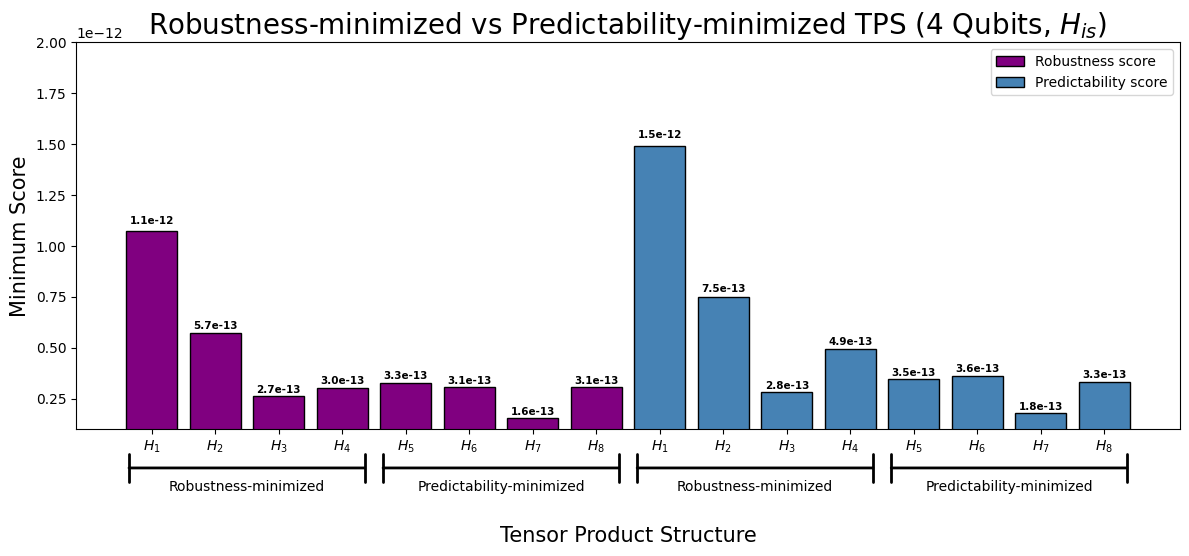

In [ ]:
### Plot minTPS ###
# rob_or_pred = 'Robustness'
# rob_or_pred = 'Predictability'
rob_or_pred = 'both'
# rob_or_pred = 'both_logscale'

# data_type = 0 for minimum, 1 for mean, 2 for variance
data_type = 0


if rob_or_pred == 'Robustness':
    orbitLabels = rob_minTPS_data[0][0]
    orbitMins = rob_minTPS_data[0][data_type + 1]
    
else:
    orbitLabels = pred_minTPS_data[0][0]
    orbitMins = pred_minTPS_data[0][data_type + 1]
genMins = [genscore_data[(data_type * 2)], genscore_data[(data_type * 2) + 1]]

n = simulation_info['n']
Ham_name = simulation_info['Ham']
title = f'{rob_or_pred}-minimized TPS ({n} Qubits, {Ham_name})'

if data_type == 0:
    ymax = 1
    if n == '2' and rob_or_pred == 'Predictability':
        ymin = 1e-17
    # elif n == '2' and rob_or_pred == 'Robustness':
    #     ymin = 1e-14
    else:
        ymax = 1
        ymin = 1e-13

elif data_type == 1:
    ymax = 1e-1
    ymin = 1e-3
else:
    ymax = 8e-4
    ymin = 1e-6

if rob_or_pred == 'both':
    data_type = 0
    title = f'Robustness-minimized vs Predictability-minimized TPS ({n} Qubits, {Ham_name})'
    orbitLabels = rob_minTPS_data[0][0]
    rob_data = rob_minTPS_data[0][data_type + 1]
    pred_data = pred_minTPS_data[0][data_type + 1]
    scale_type = 'linear'
    ymax = 2e-12
    ymin = 1e-13
    rob_and_pred_minTPS(orbitLabels, rob_data, pred_data, genMins, title, ymin, ymax, data_type, scale_type)

elif rob_or_pred == 'both_logscale':
    data_type = 0
    title = f'Robustness-minimized vs Predictability-minimized TPS ({n} Qubits, {Ham_name})'
    orbitLabels = rob_minTPS_data[0][0]
    rob_data = rob_minTPS_data[0][data_type + 1]
    pred_data = pred_minTPS_data[0][data_type + 1]
    scale_type = 'log'
    ymax = 1e-1
    ymin = 1e-12
    rob_and_pred_minTPS(orbitLabels, rob_data, pred_data, genMins, title, ymin, ymax, data_type, scale_type)

else:
    minTPS_bars(orbitLabels, orbitMins, genMins, title, ymin, ymax, data_type)


In [ ]:
# second to last parameter is for x coordinate of labels
TPS_plot(*pred_minTPS_list[0][0:5], *genscore_data[0:5], 0.5, 4.3, 'Predictability-minimized TPSs')

NameError: name 'TPS_plot' is not defined

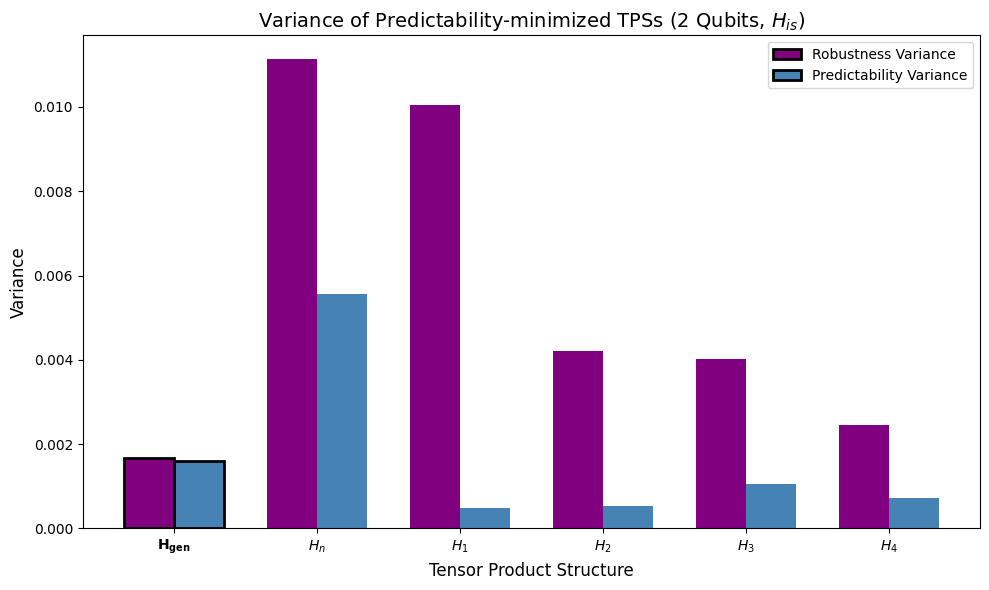

In [ ]:
variance_plot(pred_minTPS_list[0][0], pred_minTPS_list[0][4], B[4], f'Variance of Predictability-minimized TPSs ({n} Qubits, {ham_name})')

orbitScores 1 = [0.13825397546090512, 0.13257216123801463]


TypeError: 'float' object is not subscriptable

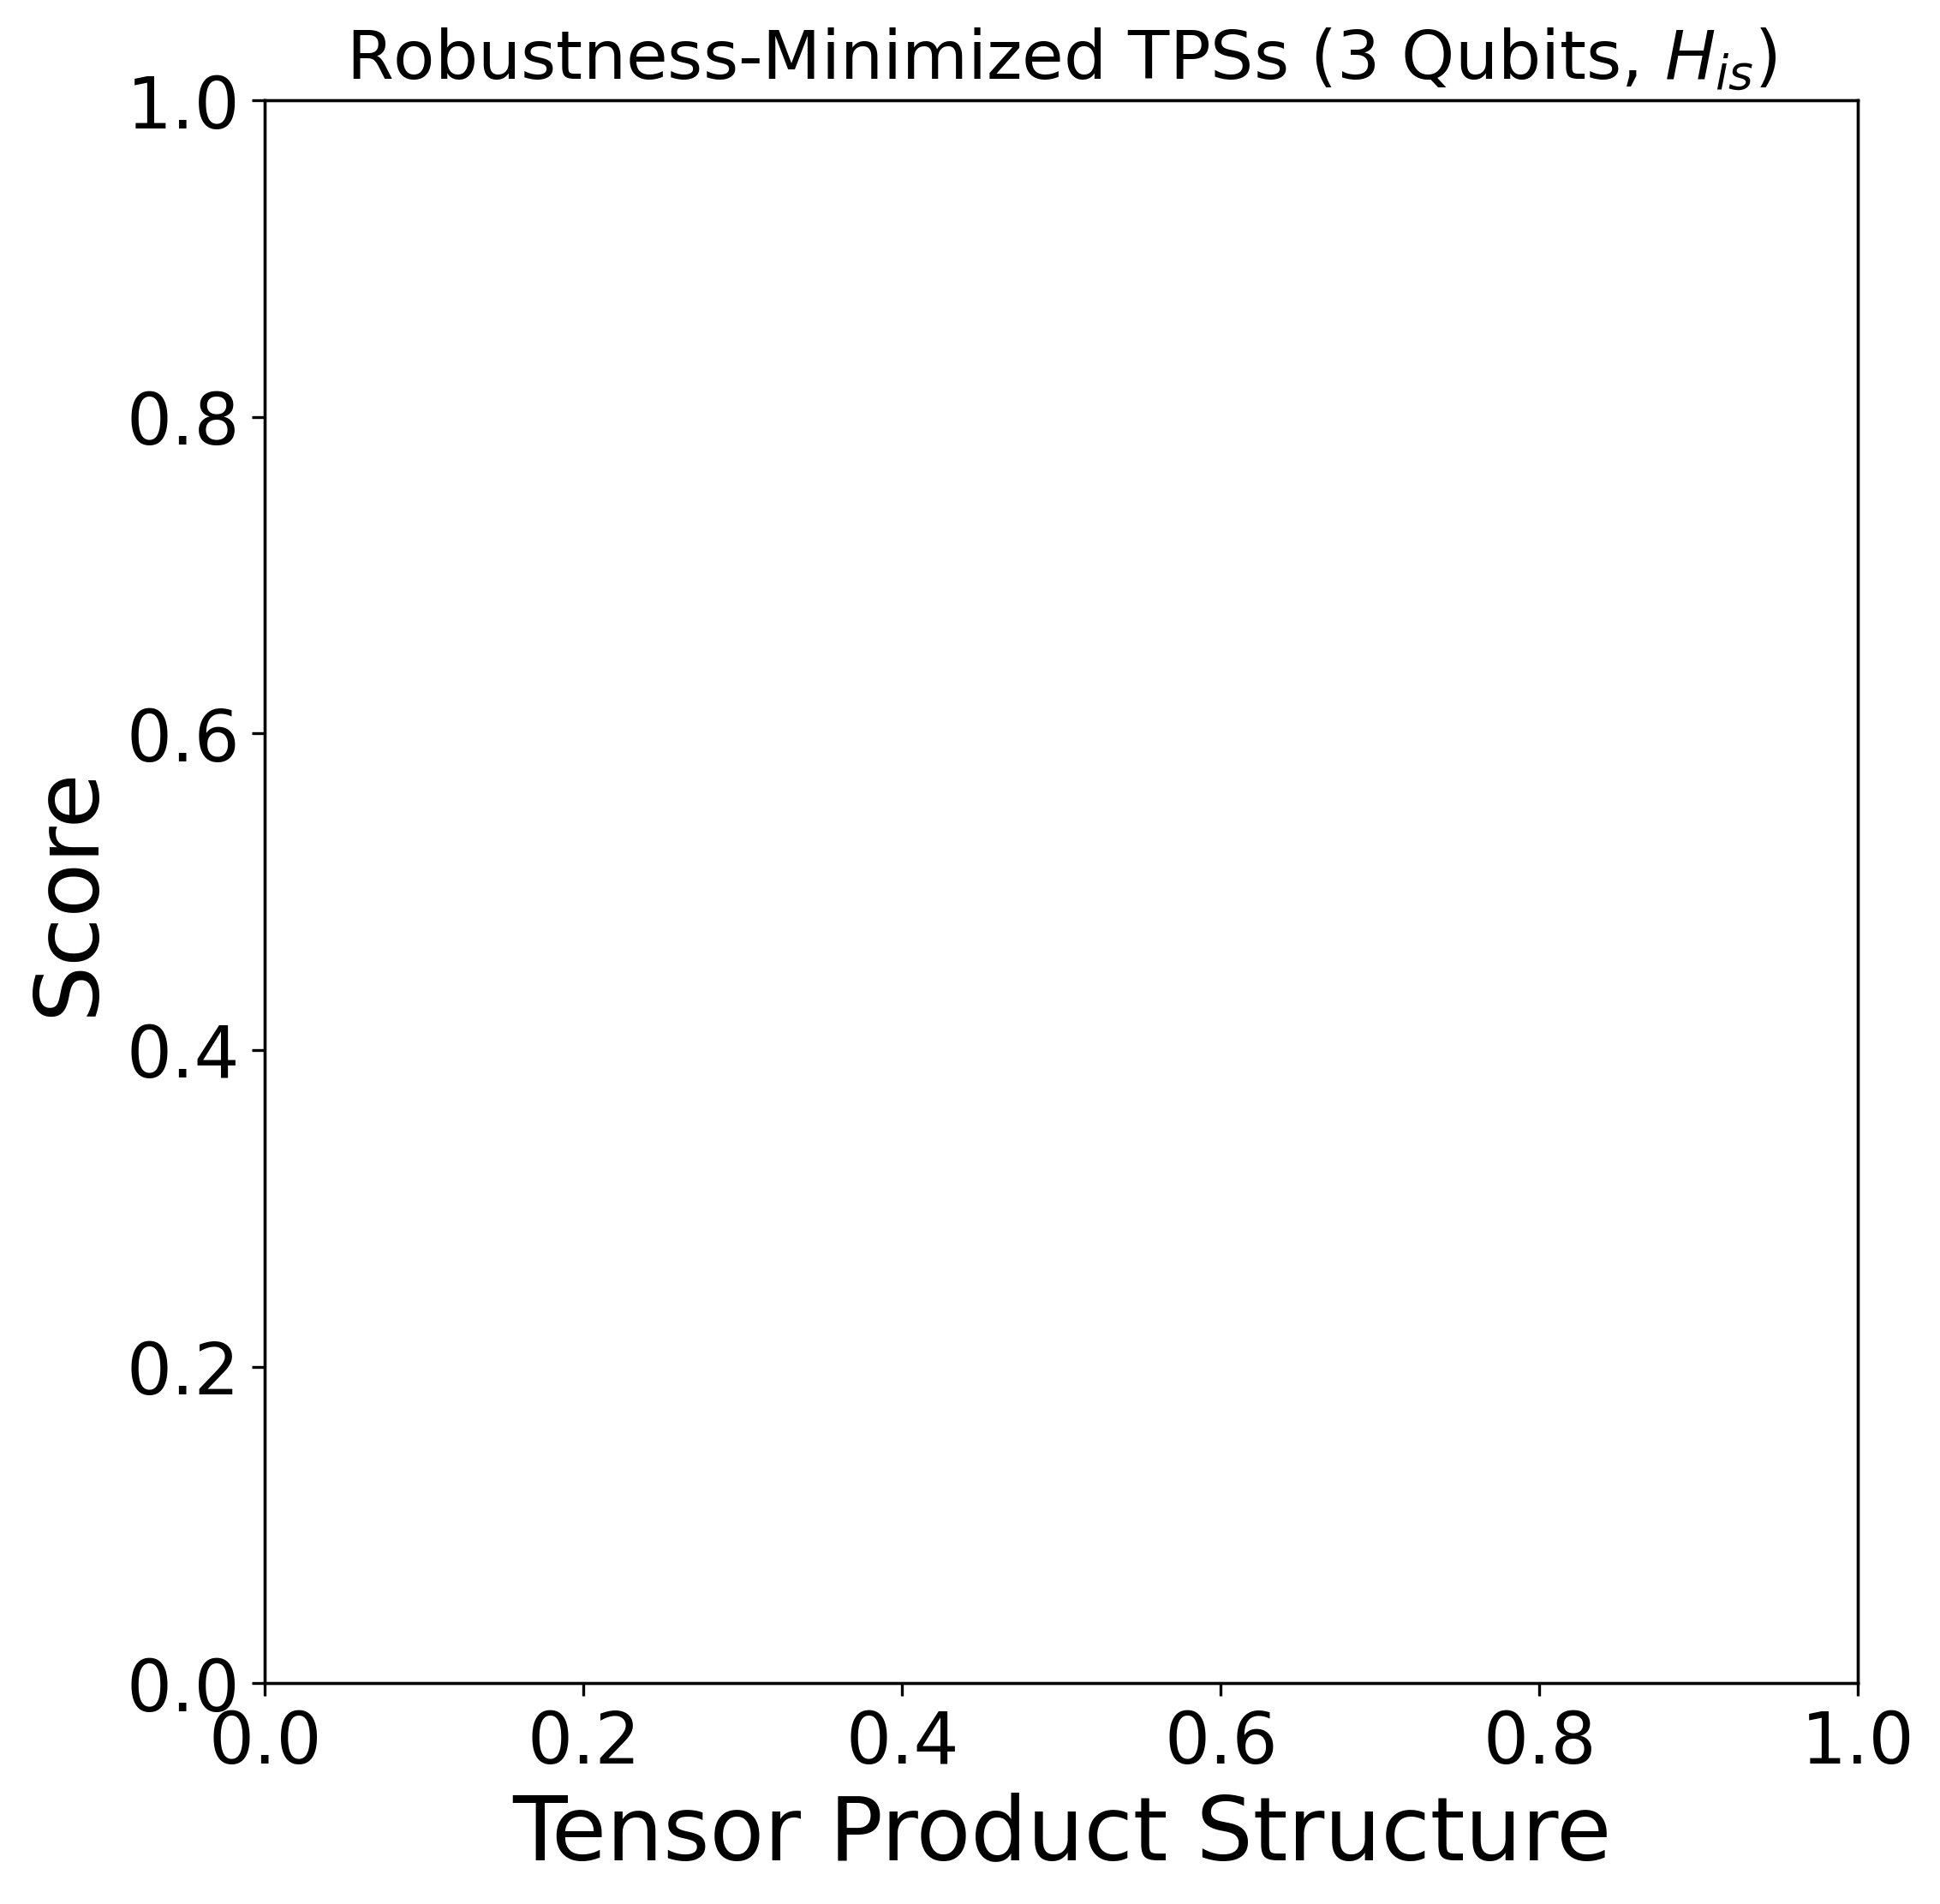

In [ ]:
# second to last parameter is xpos of labels, adjust as needed
TPS_plot(*rob_minTPS_list[0][0:5], *B[0:5], 0.5, 4.3, 'Robustness-Minimized TPSs')

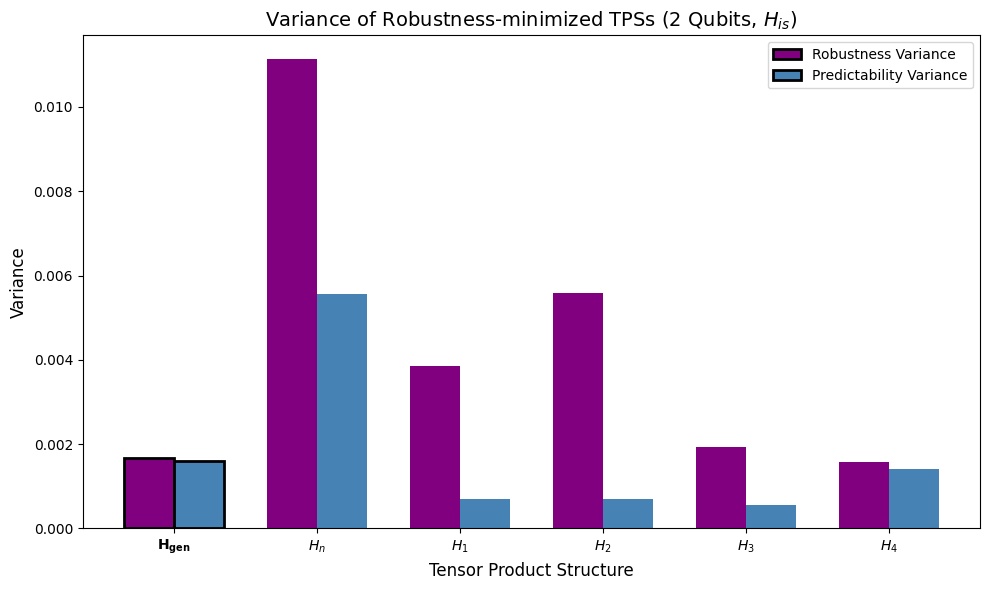

In [ ]:
variance_plot(rob_minTPS_list[0][0], rob_minTPS_list[0][4], B[4], f'Variance of Robustness-minimized TPSs ({n} Qubits, {ham_name})')

In [ ]:
# Function to record Qobj from csv

# Define a helper function to convert two-element lists into complex numbers.
def convert_complex(item):
    """
    Recursively convert two-element lists [real, imag] into complex numbers.
    """
    if isinstance(item, list):
        # If the list is exactly two numbers, assume it's a complex number.
        if len(item) == 2 and all(isinstance(x, (int, float)) for x in item):
            return complex(item[0], item[1])
        else:
            # Otherwise, apply the conversion recursively.
            return [convert_complex(x) for x in item]
    return item

# Define a helper function to convert nested lists back into a Qobj.
def recover_qobj(nested_list):
    """
    Convert a nested list (from Qobj.full().tolist()) into a Qobj.
    """
    converted_data = convert_complex(nested_list)
    return Qobj(np.array(converted_data))


# Set the CSV filename and the key corresponding to the row you wish to recover.
csv_filename = "Karpf_TPSdata.csv"
desired_key = "test_0402_2337"  

# Initialize variables to store the raw JSON data.
rob_minTPS_list_raw = None
pred_minTPS_list_raw = None

# Read the CSV file and find the row with the desired key.
with open(csv_filename, 'r', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['key'] == desired_key:
            rob_minTPS_json = row['rob_minTPS_list']
            pred_minTPS_json = row['pred_minTPS_list']
            rob_minTPS_list_raw = json.loads(rob_minTPS_json)
            pred_minTPS_list_raw = json.loads(pred_minTPS_json)
            break

# Check if data was found for the given key.
if rob_minTPS_list_raw is None or pred_minTPS_list_raw is None:
    print(f"No data found for key {desired_key}")
else:
    # Convert each element in the raw lists back to Qobj objects.
    rob_minTPS_list = [recover_qobj(item) for item in rob_minTPS_list_raw]
    pred_minTPS_list = [recover_qobj(item) for item in pred_minTPS_list_raw]

    # Now you have your recovered lists ready to use in your code.
    print("Recovered rob_minTPS_list:")
    for obj in rob_minTPS_list:
        print(obj)
        
    print("\nRecovered pred_minTPS_list:")
    for obj in pred_minTPS_list:
        print(obj)


Error: field larger than field limit (131072)

In [ ]:
# """ OLD DATA STORAGE """
# import csv
# import os
# csv_filename = "Karpf_thesis_results.csv"

# # Create CSV file with header if it doesn't exist
# if not os.path.exists(csv_filename):
#     with open(csv_filename, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         # Define header columns; adjust as needed
#         writer.writerow(["key", "rob_minTPS_list", "pred_minTPS_list", "B"])



# if "data_dict" not in globals():
#     data_dict = {}

# current_time = datetime.now().strftime("%m%d_%H%M")
# key = f'{n}qubits_{ham_name}_{current_time}'
# data_dict[key] = [rob_minTPS_list, pred_minTPS_list, genscore_data]

# print(f"Simulation result saved under key: {key}")
# print(f"Total saved results: {len(data_dict)}")
# print(data_dict.keys())


# # Append the new data to the CSV file
# with open(csv_filename, 'a', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     # Convert list objects to string format. You can use other formatting methods if needed.
#     writer.writerow([key, str(Robustness-minimized TPSs), str(Predictability-minimized TPSs), str(Generic Score Data)])

Total saved results: 0
dict_keys([])


In [ ]:
# def TPSLines_old(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, numOrbits, numLU, minimizeYorN, fn_num, threshold):
#     """Current Code Flow with Minimization:
#         1. Add native H line
#         2. Find values of theta (that parameterize a global unitary which transforms H to a distinct H of another orbit) that minimize CF1
#         3. Determine the corresponding Hamiltonian and pemutations (relabeling of tensor factors) of that Hamiltonian
#         4. Check to see if Hamiltonian is LUE to another Hamiltonian already found by the procedure
#         5. Apply LU transformations to generate entire TPS orbit (lightly colored dots on plot)
#         6. Store min and mean values of each metric
#     """

#     orbitLabels = ['$H_n$']
#     orbitSamples, orbitScores, orbitMeans, orbitVariances = [], [], [], []
#     minHams, minTPSThetas =  [], []

#     nullThetas = [0]*(dim_tot**2-1)
#     native_ham = scram(nVar, initial_hamVar, thetasVar, GGMMs, 0)   
#     NCList = []

#     # Adding native TPS first (H_0)
#     rob_score = cost(nullThetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 2) 
#     pred_score = cost(nullThetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 4) 
#     orbitScore = [rob_score, pred_score]
    
#     for i in range(numLU):
#         # determine scores across *numLU* # of local unitary transformations for plotting
#         rob_score = cost(randomThetas(1), nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 1, 1)  # scram w/ local unitary, use CF1
#         pred_score = cost(randomThetas(1), nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 1, 3)  # scram w/ local unitary, use CF3
#         orbitSamples.append([rob_score, pred_score])   # append sampled scores across LUs

#     mean_rob, var_rob = mean_variance_fn(nVar, native_ham, GGMMs, tensor_initial_statesVar, 2)
#     mean_pred, var_pred = mean_variance_fn(nVar, native_ham, GGMMs, tensor_initial_statesVar, 4)
#     orbitMean = [mean_rob, mean_pred]
#     orbitVariance = [var_rob, var_pred]


#     # save native line data
#     orbitScores.append(orbitScore)
#     orbitMeans.append(orbitMean)
#     orbitVariances.append(orbitVariance)
#     minHams.append(initial_hamVar)
#     minTPSThetas.append(nullThetas)

#     # Display native line data
#     print('#################################################')
#     print('Native TPS (data from CF2/CF4):')
#     print(f'rob_score, pred_score = {orbitScore}')
#     print(f'rob_mean, pred_mean = {orbitMean}')
#     print(f'rob_variance, pred_variance = {orbitVariance}')
#     print('#################################################')



#     # search for other qcTPS
#     l = 1
#     while l != numOrbits:
#         orbitLabels.append(f'$H_{l}$')         
#         k = 2
#         while k != 0: # a.k.a. while TPS line is not distinct (LUE to previous line)
#             if minimizeYorN == 0:
#                 # No gradient descent is applied, function will plot random distinct TPS lines regardless if they are quasi-classical or not
#                 scramHam = scram(nVar, initial_hamVar, randomThetas(0), GGMMs, 0)
#                 allHams = APHam(nVar, scramHam)
#                 rob_score = cost(nullThetas, nVar, scramHam, GGMMs, tensor_initial_statesVar, 0, 2)
#                 pred_score = cost(nullThetas, nVar, scramHam, GGMMs, tensor_initial_statesVar, 0, 3)
            
#             elif minimizeYorN == 1:
#                 # Gradient descent to find quasi-classical TPS, only saves data from qcTPS
#                 print(f'\nMinimizing...')
#                 if fn_num == 1:                
#                     rob1_score, min_thetas = minimizeCF(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, fn_num, threshold)
#                     #score, thetas = minimizeCF1bh(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar)  
#                     pred3_score = cost(min_thetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 3)
                    
#                 elif fn_num == 3:                
#                     pred3_score, min_thetas = minimizeCF(nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, fn_num, threshold) 
#                     rob1_score = cost(min_thetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 1)

#                 # compute cf2, cf4 for the TPS
#                 rob2_score = cost(min_thetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 2)
#                 pred4_score = cost(min_thetas, nVar, initial_hamVar, GGMMs, tensor_initial_statesVar, 0, 4)

#                 # Append minThetas
#                 minTPSThetas.append(min_thetas)
                
#                 orbitScore13 = [[rob1_score, pred3_score]]
#                 orbitScore24 = [[rob2_score, pred4_score]]
#                 print(f'Done minimizing.')


#             # Check to ensure the found qcTPS isn't LUE to previously found qcTPS
#             print(f'Performing LUE check.')
#             NCList = []
#             scramHam = scram(nVar, initial_hamVar, min_thetas, GGMMs, 0)
#             allHams = permuteHam(nVar, scramHam) 
#             for i in range(len(minHams)):
#                 for j in range(len(allHams)):
#                     NCList.append(NC(nVar, allHams[j], minHams[i]))
#             if NCList == [0]*(len(allHams)*len(minHams)):
#                 print('\n#################################################')
#                 print(f'Distinct qcTPS found. Number of saved TPSs: {l+1}')
#                 minHams.append(scramHam)
#                 k = 0
#             else:
#                 print('Ambiguous TPS line found. Trying again.')        # LUE to previous TPS orbit
#                 minTPSThetas.pop()
#                 orbitScore.pop()
#                 k = 2

#         orbitSample = []
#         for i in range(numLU):
#         # Apply local unitary operators to H to generate a given TPS orbit
#             lu_thetas = randomThetas(1)
#             lu_rob_score = cost(lu_thetas, nVar, scramHam, GGMMs, tensor_initial_statesVar, 1, 1)
#             lu_pred_score = cost(lu_thetas, nVar, scramHam, GGMMs, tensor_initial_statesVar, 1, 3)
#             lu_score = [lu_rob_score, lu_pred_score]
#             orbitSample.append(lu_score)
       


#         # compute the mean and variance (exact value, uses CF2/CF4)
#         min_ham = scram(nVar, initial_hamVar, min_thetas, GGMMs, 0)   
#         mean_rob, var_rob = [], []
#         mean_pred, var_pred = [], []
#         orbitMean = []
#         orbitVariance = []
#         mean_rob, var_rob = mean_variance_fn(nVar, min_ham, GGMMs, tensor_initial_statesVar, 2)
#         mean_pred, var_pred = mean_variance_fn(nVar, min_ham, GGMMs, tensor_initial_statesVar, 4)
#         orbitMean = [mean_rob, mean_pred]
#         orbitVariance = [var_rob, var_pred]

#         # compute the sampled mean, variance across LUs for visualization
#         orbitSample_arr = np.array(orbitSample)
#         orbitSample_mean = np.mean(orbitSample_arr, axis=0).tolist()
#         orbitSample_variance = np.var(orbitSample_arr, axis=0).tolist()

#         # Save the orbit data, NOTICE WHICH ORBIT SCORE IS SAVED (CF1/3 or CF2/4)
#         orbitScores.append(orbitScore24)     #### IMPORTANT ####
#         orbitMeans.append(orbitMean)
#         orbitVariances.append(orbitVariance)
#         orbitSamples.append(orbitSample)

#         # Display Raw data (CF1, CF2, CF3, CF4)
#         print(f'rob1_score, pred3_score = {orbitScore13}')
#         print(f'rob2_score, pred4_score = {orbitScore24}')

#         print(f'\nexact_mean* = {orbitMean}')
#         print(f'orbitSample_mean = {orbitSample_mean}')

#         print(f'\nexact_variance* = {orbitVariance}')
#         print(f'orbitSample_variance = {orbitSample_variance}')

#         # Display Saved data
#         print('\nSaved Data:')
#         print(f'rob_score, pred_score = {orbitScore24}')
#         print(f'rob_mean, pred_mean = {orbitMean}')
#         print(f'rob_variance, pred_variance = {orbitVariance}')
#         print('#################################################')


#         # Find another qcTPS / exit loop
#         l += 1


#     # # for each orbit, compute the mean and min across LUs
#     # for i in range(len(orbitScores)):
#     #     # Extract the correct scores from each subsublist
#     #     rob_scores = [ent[0] for ent in orbitScores[i]]
#     #     print(f'new_rob_scores: {rob_scores}')
#     #     pred_scores = [ent[1] for ent in orbitScores[i]]

#     #     rob_mean = np.mean(rob_scores)
#     #     rob_min = np.min(rob_scores)
#     #     pred_mean = np.mean(pred_scores)
#     #     pred_min = np.min(pred_scores)

#     #     meanOScores2.append([rob_mean, pred_mean])
#     #     minOScores2.append([rob_min, pred_min])     

#     #     print(f'meanOScores1 = {meanOScores1}')
#     #     print(f'meanOScores2 = {meanOScores2}')
#     #     print(f'minOScores1 = {minOScores1}')
  
#     #     print(f'minOScores2 = {minOScores2}')

#     #     # print(f'minOScores = {minOScores}, variance = {orbitVariances[i]}')    

#     return orbitLabels, orbitSamples, orbitScores, orbitMeans, orbitVariances, minHams, minTPSThetas, numLU

## This Section contains old code that has been used for debugging:

In [ ]:
# Debugging CF1/CF2
nullThetas = [0]*(dim_tot**2-1)

random_Ham = scram(n, initial_ham, randomThetas(0), totGGMMs, 0)
# print(f'randomHam: \n{random_Ham}')

# add scores for nullThetas
# cf1_val = cost(nullThetas, n, random_Ham, totGGMMs, tensor_initial_states, 0, 1)
# cf2_val = cost(nullThetas, n, random_Ham, totGGMMs, tensor_initial_states, 0, 2)

#############################################
# Cost fn initialization
permed_scores = []
scramHamVar = scram(n, random_Ham, nullThetas, totGGMMs, 0)  


# CF1 computation native:
allHams = permuteHam(n, scramHamVar)   
allRhos = permuteHam(n, tensor_initial_states[0])
tau = te.characteristic_time(scramHamVar)
TEO = (-1j*scramHamVar*tau).expm()
# initialize lists containing the robustness entropy of TPS over all permutations (but not yet considering LU transformations)
rob_ents = []
# Test every permutation of rhos (relabeling of system qubit)
for j in range(len(allRhos)):
    rhoTau = TEO*allRhos[j]*TEO.dag()             # time evolve den mat
    rhoTauRed = rhoTau.ptrace(j)                  # trace out environment, leaving reduced den mat of system

    rob_ent = 1 - (rhoTauRed*rhoTauRed).tr()      # compute the entanglement entropy (robustness)
    rob_ents.append(rob_ent)
cf1_val = max(rob_ents)   

#############################################
# CF2 computation:
sigma = [sigmax(), sigmay(), sigmaz()]
I_env = [qeye(2)]*(n - 1)
for j in range(len(allHams)):
    tau = te.characteristic_time(allHams[j])
    Q_a = [0]*3
    redQ_a = [0]*3
    for i in range(3):
        Q_a[i] = (1/(2**(n - 1)))*te.time_evolution(tensor([sigma[i]] + I_env), allHams[j], tau)
        redQ_a[i] = Q_a[i].ptrace(0)
        redQ_a[i] = redQ_a[i].full()
        # print(f'\n redQ_a full: \n{redQ_a}') 

    M_ab = [[(np.matmul(redQ_a[0], redQ_a[0])).trace(), (np.matmul(redQ_a[0], redQ_a[1])).trace(), (np.matmul(redQ_a[0], redQ_a[2])).trace()],
            [(np.matmul(redQ_a[1], redQ_a[0])).trace(), (np.matmul(redQ_a[1], redQ_a[1])).trace(), (np.matmul(redQ_a[1], redQ_a[2])).trace()],
            [(np.matmul(redQ_a[2], redQ_a[0])).trace(), (np.matmul(redQ_a[2], redQ_a[1])).trace(), (np.matmul(redQ_a[2], redQ_a[2])).trace()]]
    eig = np.linalg.eigh(M_ab)
    maxEigenValue = max(eig[0])
    score = (1/2) - (1/4)*maxEigenValue
    permed_scores.append(score)
cf2_val = max(permed_scores)



print(f'CF1 native: {cf1_val}')
print(f'CF2: {cf2_val}')

if cf1_val < cf2_val:
    throw_error

#############################################
# CF1 computation LUs:
numLU = 1000
cf1_lus = []
for i in range(numLU):
    # Initialization:
    lu_thetas = randomThetas(1)
    scramHamVar = scram(n, random_Ham, lu_thetas, selfGGMMs, 1) 
    allHams = permuteHam(n, scramHamVar)    



    # compute CF1:
    allRhos = permuteHam(n, tensor_initial_states[0])
    tau = te.characteristic_time(scramHamVar)
    TEO = (-1j*scramHamVar*tau).expm()
    # initialize lists containing the robustness entropy of TPS over all permutations (but not yet considering LU transformations)
    rob_ents = []
    # Test every permutation of rhos (relabeling of system qubit)
    for j in range(len(allRhos)):
        rhoTau = TEO*allRhos[j]*TEO.dag()             # time evolve den mat
        rhoTauRed = rhoTau.ptrace(j)                  # trace out environment, leaving reduced den mat of system

        rob_ent = 1 - (rhoTauRed*rhoTauRed).tr()      # compute the entanglement entropy (robustness)
        rob_ents.append(rob_ent)
    cf1_lus.append(max(rob_ents))

    if cf1_lus[i] < cf2_val:
        print(f'CF1 LU val: {cf1_lus[i]}')
        print(f'CF2 val: {cf2_val}')
        print(f'lu_thetas: {lu_thetas}')
        print(f'randomHam: {random_Ham}')
        print(f'scramHamVar: {scramHamVar}')
        thetas_error = lu_thetas
        print(f'LUE check: {NC(n, random_Ham, scramHamVar)}')
        throw_error

    # CF2 computation across LUs:
    sigma = [sigmax(), sigmay(), sigmaz()]
    I_env = [qeye(2)]*(n - 1)
    permed_scores = []
    for j in range(len(allHams)):
        tau = te.characteristic_time(allHams[j])
        Q_a = [0]*3
        redQ_a = [0]*3
        for i in range(3):

        # ############################################## TESTING
        #     Q_a[i] = (1/(2**(n - 1)))*te.time_evolution(tensor([sigma[i]] + I_env), allHams[j], tau)


        #     # After computing the full reduced operator:
        #     full_redQ = Q_a[i].ptrace(0).full()
        #     eigvals = np.linalg.eigvals(full_redQ)
        #     print(f"\nLU {LU}, sigma[{i+1}], permutation {j}:")
        #     print("full_redQ =", full_redQ)
        #     print("Eigenvalues =", max(eigvals))
        # ############################################## TESTING
        
            Q_a[i] = (1/(2**(n - 1)))*te.time_evolution(tensor([sigma[i]] + I_env), allHams[j], tau)
            redQ_a[i] = Q_a[i].ptrace(0)
            redQ_a[i] = redQ_a[i].full()
            # print(f'\n redQ_a full: \n{redQ_a}') 

        M_ab = [[(np.matmul(redQ_a[0], redQ_a[0])).trace(), (np.matmul(redQ_a[0], redQ_a[1])).trace(), (np.matmul(redQ_a[0], redQ_a[2])).trace()],
                [(np.matmul(redQ_a[1], redQ_a[0])).trace(), (np.matmul(redQ_a[1], redQ_a[1])).trace(), (np.matmul(redQ_a[1], redQ_a[2])).trace()],
                [(np.matmul(redQ_a[2], redQ_a[0])).trace(), (np.matmul(redQ_a[2], redQ_a[1])).trace(), (np.matmul(redQ_a[2], redQ_a[2])).trace()]]
        eig = np.linalg.eigh(M_ab)
        maxEigenValue = max(eig[0])
        score = (1/2) - (1/4)*maxEigenValue
        permed_scores.append(score)
    cf2_val_new  = max(permed_scores)
    print(f'cf2_val_new: {cf2_val_new}')

cf1_min = min(cf1_lus)

print(f'CF1 min: {cf1_min}')
print(f'CF2: {cf2_val}')

if cf1_min < cf2_val:
    throw_error



CF1 native: 0.10596426654332647
CF2: 0.09590975037993521
cf2_val_new: 0.09590975037993543
cf2_val_new: 0.09590975037993543
cf2_val_new: 0.09590975037993538
cf2_val_new: 0.09590975037993543
cf2_val_new: 0.09590975037993515
cf2_val_new: 0.09590975037993527
cf2_val_new: 0.0959097503799351
cf2_val_new: 0.09590975037993549
cf2_val_new: 0.09590975037993554
cf2_val_new: 0.09590975037993515
cf2_val_new: 0.09590975037993532
cf2_val_new: 0.09590975037993521
cf2_val_new: 0.09590975037993521
cf2_val_new: 0.09590975037993515
cf2_val_new: 0.09590975037993554
cf2_val_new: 0.09590975037993521
cf2_val_new: 0.09590975037993543
cf2_val_new: 0.09590975037993515
cf2_val_new: 0.09590975037993538
cf2_val_new: 0.09590975037993538
cf2_val_new: 0.09590975037993527
cf2_val_new: 0.09590975037993532
cf2_val_new: 0.09590975037993515
cf2_val_new: 0.09590975037993527
cf2_val_new: 0.09590975037993532
cf2_val_new: 0.09590975037993532
cf2_val_new: 0.09590975037993532
cf2_val_new: 0.09590975037993521
cf2_val_new: 0.09590

In [ ]:
###################### CF2 vs CF4 across LUs ######################

nullThetas = [0]*(dim_tot**2-1)
random_Ham = scram(n, initial_ham, randomThetas(0), totGGMMs, 0)

numLU = 100
for i in range(numLU):
    # Initialization:
    lu_thetas = randomThetas(1)
    random_Ham_LU = scram(n, random_Ham, lu_thetas, totGGMMs, 1) 
    allHams = permuteHam(n, random_Ham_LU)    

    if NC(n, random_Ham, random_Ham_LU) == 0:
        print('Hams are not LUE !!!')

    #  computation across LUs:
    sigma = [sigmax(), sigmay(), sigmaz()]
    I_env = [qeye(2)]*(n - 1)
    coord_scores = []
    for j in range(len(allHams)):
        tau = te.characteristic_time(allHams[j])
        Q_a = [0]*3
        redQ_a = [0]*3
        for i in range(3):
            Q_a[i] = (1/(2**(n - 1)))*te.time_evolution(tensor([sigma[i]] + I_env), allHams[j], tau)
            redQ_a[i] = (Q_a[i].ptrace(0)).full()
            # print(f'\n redQ_a full: \n{redQ_a}') 
            # Ensure Q_a is Hermitian
            if not Q_a[i].isherm:
                print("The matrix is not Hermitian!")

            if abs((redQ_a[i])[0,0] + (redQ_a[i])[1,1]) > 1e6:
                print('Expected asymmetry not present !!!')

                
            # print(f'red(Q alpha): {redQ_a}')
    ########################### CF4 #############################

        P_ab = np.array([[(np.matmul(sigma[0].full(), redQ_a[0])).trace(), (np.matmul(sigma[0].full(), redQ_a[1])).trace(), (np.matmul(sigma[0].full(), redQ_a[2])).trace()],
                    [(np.matmul(sigma[1].full(), redQ_a[0])).trace(), (np.matmul(sigma[1].full(), redQ_a[1])).trace(), (np.matmul(sigma[1].full(), redQ_a[2])).trace()],
                    [(np.matmul(sigma[2].full(), redQ_a[0])).trace(), (np.matmul(sigma[2].full(), redQ_a[1])).trace(), (np.matmul(sigma[2].full(), redQ_a[2])).trace()]])

        P_ba = np.array([[(np.matmul(sigma[0].full(), redQ_a[0])).trace(), (np.matmul(sigma[1].full(), redQ_a[0])).trace(), (np.matmul(sigma[2].full(), redQ_a[0])).trace()],
                    [(np.matmul(sigma[0].full(), redQ_a[1])).trace(), (np.matmul(sigma[1].full(), redQ_a[1])).trace(), (np.matmul(sigma[2].full(), redQ_a[1])).trace()],
                    [(np.matmul(sigma[0].full(), redQ_a[2])).trace(), (np.matmul(sigma[1].full(), redQ_a[2])).trace(), (np.matmul(sigma[2].full(), redQ_a[2])).trace()]])

        P_tilda = (1/2)*(P_ab + P_ba)

        if not np.allclose(np.array(P_tilda), np.array(P_tilda).T):
            print("P_tilda is not symmetric !!!")
            
        eig = np.linalg.eigvalsh(P_tilda)
        maxEigenValue = max(eig)
        score = 1/2 - (1/8)*(maxEigenValue**2)
        coord_scores.append(score)
    cf4_val_new = max(coord_scores)
    print(f'cf4_val_LU: {cf4_val_new}')
    ########################### CF4 #############################

    # ############################ CF2 #############################
    #     M_ab = np.real([[(np.matmul(redQ_a[0], redQ_a[0])).trace(), (np.matmul(redQ_a[0], redQ_a[1])).trace(), (np.matmul(redQ_a[0], redQ_a[2])).trace()],
    #                     [(np.matmul(redQ_a[1], redQ_a[0])).trace(), (np.matmul(redQ_a[1], redQ_a[1])).trace(), (np.matmul(redQ_a[1], redQ_a[2])).trace()],
    #                     [(np.matmul(redQ_a[2], redQ_a[0])).trace(), (np.matmul(redQ_a[2], redQ_a[1])).trace(), (np.matmul(redQ_a[2], redQ_a[2])).trace()]])
    #     eig = np.linalg.eigvalsh(M_ab)
    #     maxEigenValue = max(eig)
    #     score = (1/2) - (1/4)*maxEigenValue
    #     permed_scores.append(score)
    # cf2_val_new  = max(permed_scores)
    # print(f'cf2_val_LU: {cf2_val_new}')
    # ############################ CF2 #############################


cf4_val_LU: 0.10396958884881352
cf4_val_LU: 0.1039695888488133
cf4_val_LU: 0.10396958884881341
cf4_val_LU: 0.1039695888488133
cf4_val_LU: 0.10396958884881358
cf4_val_LU: 0.10396958884881341
cf4_val_LU: 0.10396958884881352
cf4_val_LU: 0.10396958884881358
cf4_val_LU: 0.10396958884881352
cf4_val_LU: 0.10396958884881369
cf4_val_LU: 0.10396958884881341
cf4_val_LU: 0.10396958884881341
cf4_val_LU: 0.1039695888488133
cf4_val_LU: 0.10396958884881358
cf4_val_LU: 0.10396958884881291
cf4_val_LU: 0.10396958884881352
cf4_val_LU: 0.10396958884881352
cf4_val_LU: 0.10396958884881291
cf4_val_LU: 0.10396958884881319
cf4_val_LU: 0.10396958884881358
cf4_val_LU: 0.1039695888488133
cf4_val_LU: 0.1039695888488133
cf4_val_LU: 0.10396958884881341
cf4_val_LU: 0.10396958884881341
cf4_val_LU: 0.1039695888488138
cf4_val_LU: 0.1039695888488133
cf4_val_LU: 0.10396958884881308
cf4_val_LU: 0.1039695888488133
cf4_val_LU: 0.10396958884881341
cf4_val_LU: 0.10396958884881358
cf4_val_LU: 0.10396958884881341
cf4_val_LU: 0.10

In [ ]:
# Debugging CF3/CF4
nullThetas = [0]*(dim_tot**2-1)
random_Ham = scram(n, initial_ham, randomThetas(0), totGGMMs, 0)


#############################################
# Cost fn initialization
permed_scores = []
allHams = permuteHam(n, random_Ham)    


# CF3 computation native:
allRhos = permuteHam(n, tensor_initial_states[0])
tau = te.characteristic_time(random_Ham)
TEO = (-1j*random_Ham*tau).expm()
# initialize lists containing the entropies of TPS over all permutations (but not yet considering LU transformations)
pred_ents = []
# Test every permutation of rhos (relabeling of system qubit)
for j in range(len(allRhos)):
    rhoTau = TEO*allRhos[j]*TEO.dag()             # time evolve den mat
    rhoTauRed = rhoTau.ptrace(j)                  # trace out environment, leaving reduced den mat of system
    diag_elts = rhoTauRed.diag()  
    pred_ent = 1 - (diag_elts[0]**2 + diag_elts[1]**2)     # compute the pointer entropy (predictability)
    pred_ents.append(pred_ent)                     
cf3_val = max(pred_ents)    # return maximum pointer entropy over all permutations
print(f'cf3_val native: {cf3_val}')

#############################################
# CF4 computation:
coord_scores = []
sigma = [sigmax(), sigmay(), sigmaz()]
I_env = [qeye(2)]*(n - 1)
for j in range(len(allHams)):
    tau = te.characteristic_time(allHams[j])
    Q_a = [0]*3
    redQ_a = [0]*3
    for i in range(3):
        Q_a[i] = (1/(2**(n - 1)))*te.time_evolution(tensor([sigma[i]] + I_env), allHams[j], tau)
        redQ_a[i] = (Q_a[i].ptrace(0))

    P_ab = np.array([[(sigma[0] * redQ_a[0]).tr(), (sigma[0] * redQ_a[1]).tr(), (sigma[0] * redQ_a[2]).tr()],
                    [(sigma[1] * redQ_a[0]).tr(), (sigma[1] * redQ_a[1]).tr(), (sigma[1] * redQ_a[2]).tr()],
                    [(sigma[2] * redQ_a[0]).tr(), (sigma[2] * redQ_a[1]).tr(), (sigma[2] * redQ_a[2]).tr()]])


    P_ba = np.array([[(sigma[0] * redQ_a[0]).tr(), (sigma[1] * redQ_a[0]).tr(), (sigma[2] * redQ_a[0]).tr()],
                    [(sigma[0] * redQ_a[1]).tr(), (sigma[1] * redQ_a[1]).tr(), (sigma[2] * redQ_a[1]).tr()],
                    [(sigma[0] * redQ_a[2]).tr(), (sigma[1] * redQ_a[2]).tr(), (sigma[2] * redQ_a[2]).tr()]])

    P_tilda = (1/2)*(P_ab + P_ba)

    if not np.allclose(np.array(P_tilda), np.array(P_tilda).T):
        print("P_tilda is not symmetric !!!")
        
    eig = np.linalg.eigvalsh(P_tilda)
    maxEigenValue = max(eig)
    score = 1/2 - (1/8)*(maxEigenValue**2)
    coord_scores.append(score)
cf4_val = max(coord_scores)
print(f'cf4_val: {cf4_val}')

if cf3_val < cf4_val:
    print(f'CF3 native: {cf3_val}')
    print(f'CF4: {cf4_val}')
    throw_error



#############################################
# Computation across LUs:
numLU = 1000000
cf3_lus = []
for i in range(numLU):
    # Initialization:
    lu_thetas = randomThetas(1)
    scramHamVar = scram(n, random_Ham, lu_thetas, selfGGMMs, 1) 
    allHams = permuteHam(n, scramHamVar)    


    # compute CF3:
    allRhos = permuteHam(n, tensor_initial_states[0])
    tau = te.characteristic_time(scramHamVar)
    TEO = (-1j*scramHamVar*tau).expm()
    pred_ents = []
    # Test every permutation of rhos (relabeling of system qubit)
    for j in range(len(allRhos)):
        rhoTau = TEO * allRhos[j] * TEO.dag()             # time evolve density matrix
        rhoTauRed = rhoTau.ptrace(j)                       # reduced density matrix (2x2)
        
        # NEW LINE: Transform reduced density matrix into the pointer basis
        rhoTauRed = U_ptr.dag() * rhoTauRed * U_ptr
        
        diag_elts = rhoTauRed.diag()  
        pred_ent = 1 - (diag_elts[0]**2 + diag_elts[1]**2)  # compute the pointer entropy (predictability)
        pred_ents.append(pred_ent)  
    cf3_lu = max(pred_ents)         
    # print(f'cf3_lu: {cf3_lu}')          
    cf3_lus.append(cf3_lu) 


    if cf3_lu < cf4_val:
        print(f'CF3 LU val: {cf3_lus[i]}')
        print(f'CF4 val: {cf4_val}')
        print(f'lu_thetas: {lu_thetas}')
        print(f'randomHam: {random_Ham}')
        print(f'scramHamVar: {scramHamVar}')
        thetas_error = lu_thetas
        print(f'LUE check: {NC(n, random_Ham, scramHamVar)}')
        throw_error

    # # CF4 computation across LUs:
    # coord_scores = []
    # sigma = [sigmax(), sigmay(), sigmaz()]
    # I_env = [qeye(2)]*(n - 1)
    # for j in range(len(allHams)):
    #     tau = te.characteristic_time(allHams[j])
    #     Q_a = [0]*3
    #     redQ_a = [0]*3
    #     for i in range(3):
    #         Q_a[i] = (1/(2**(n - 1)))*te.time_evolution(tensor([sigma[i]] + I_env), allHams[j], tau)
    #         redQ_a[i] = (Q_a[i].ptrace(0))
    #         # print(f'ASYMMETRY? \n {(redQ_a[i].full())[0,0]}, {(redQ_a[i].full())[1,1]}')

    #     # print(f'\n redQ_a final: {redQ_a}')

    #     P_ab = np.array([[(sigma[0] * redQ_a[0]).tr(), (sigma[0] * redQ_a[1]).tr(), (sigma[0] * redQ_a[2]).tr()],
    #                     [(sigma[1] * redQ_a[0]).tr(), (sigma[1] * redQ_a[1]).tr(), (sigma[1] * redQ_a[2]).tr()],
    #                     [(sigma[2] * redQ_a[0]).tr(), (sigma[2] * redQ_a[1]).tr(), (sigma[2] * redQ_a[2]).tr()]])


    #     P_ba = np.array([[(sigma[0] * redQ_a[0]).tr(), (sigma[1] * redQ_a[0]).tr(), (sigma[2] * redQ_a[0]).tr()],
    #                     [(sigma[0] * redQ_a[1]).tr(), (sigma[1] * redQ_a[1]).tr(), (sigma[2] * redQ_a[1]).tr()],
    #                     [(sigma[0] * redQ_a[2]).tr(), (sigma[1] * redQ_a[2]).tr(), (sigma[2] * redQ_a[2]).tr()]])

    #     P_tilda = (1/2)*(P_ab + P_ba)

    #     if not np.allclose(np.array(P_tilda), np.array(P_tilda).T):
    #         print("P_tilda is not symmetric !!!")
            
    #     eig = np.linalg.eigvalsh(P_tilda)
    #     maxEigenValue = max(eig)
    #     score = 1/2 - (1/8)*(maxEigenValue**2)
    #     coord_scores.append(score)
    # cf4_val_new = max(coord_scores)
    # print(f'cf4_val: {cf4_val_new}')
    # # cf4_val_new = max(permed_scores)
    # # print(f'cf4_val_new: {cf4_val_new}')


cf3_min = min(cf3_lus)

print(f'CF3 min: {cf3_min}')
print(f'CF4: {cf4_val}')

# if cf3_min < cf4_val:
#     throw_error

cf3_val native: 0.12818519129156059
cf4_val: 0.10895698013749583


KeyboardInterrupt: 

In [ ]:
#### DEBUGGING CF4 ACROSS LUS ####

# Initial_Ham
random_Ham = scram(n, initial_ham, randomThetas(0), totGGMMs, 0)
# print(f'randomHam: \n{random_Ham}')

#############################################
# CF4 computation LUs:
numLU = 50
for LU in range(numLU):
    # Initialization:
    lu_thetas = randomThetas(1)
    LU_random_Ham = scram(n, random_Ham, lu_thetas, selfGGMMs, 1) 
    allHams = permuteHam(n, LU_random_Ham)     


    if NC(n, random_Ham, LU_random_Ham) == 0:
        print('Hams are not LUE !!!')

    # Extra for CF2 ############################################################################################
    cf2_permed_scores = []
    ############################################################################################


    # CF4 computation across LUs:
    permed_scores = []
    sigma = [sigmax(), sigmay(), sigmaz()]
    I_env = [qeye(2)]*(n - 1)
    for j in range(len(allHams)):
        tau = te.characteristic_time(allHams[j])
        Q_a = [0]*3
        redQ_a = [0]*3
        redQ_a_00 = [0]*3
        for i in range(3):
            Q_a[i] = (1/(2**(n - 1)))*te.time_evolution(tensor([sigma[i]] + I_env), allHams[j], tau)


            # # After computing the full reduced operator:
            # full_redQ = Q_a[i].ptrace(0).full()
            # eigvals = np.linalg.eigvals(full_redQ)
            # print(f"\nLU {LU}, sigma[{i+1}], permutation {j}:")
            # print("full_redQ =", full_redQ)
            # print("Eigenvalues =", eigvals)


            redQ_a[i] = (Q_a[i].ptrace(0)).full()

            if abs((redQ_a[i])[0,0] + (redQ_a[i])[1,1]) > 1e6:
                print('Expected asymmetry not present !!!')

                
            # print(f'ASYMMETRY? \n {(redQ_a[i].full())[0,0]}, {(redQ_a[i].full())[1,1]}')

            # ¡! take (0,0) element !¡
            redQ_a_00[i] = (redQ_a[i])[0,0]


        # checking to ensure consistency with CF2 ##############################################
        M_ab = [[(np.matmul(redQ_a[0], redQ_a[0])).trace(), (np.matmul(redQ_a[0], redQ_a[1])).trace(), (np.matmul(redQ_a[0], redQ_a[2])).trace()],
                [(np.matmul(redQ_a[1], redQ_a[0])).trace(), (np.matmul(redQ_a[1], redQ_a[1])).trace(), (np.matmul(redQ_a[1], redQ_a[2])).trace()],
                [(np.matmul(redQ_a[2], redQ_a[0])).trace(), (np.matmul(redQ_a[2], redQ_a[1])).trace(), (np.matmul(redQ_a[2], redQ_a[2])).trace()]]
        eig_cf2 = np.linalg.eigh(M_ab)
        maxEigenValue_cf2 = max(eig_cf2[0])
        cf2_score = (1/2) - (1/4)*maxEigenValue_cf2
        cf2_permed_scores.append(cf2_score)
        ############################################################################################


        # vec = [redQ_a[0], redQ_a[1], redQ_a[2]]
        # print("redQ vector:", vec, "Norm:", np.linalg.norm(vec))
        # print(f'\n redQ_a final: {redQ_a}')
        K_ab = [[(redQ_a_00[0] * redQ_a_00[0]), (redQ_a_00[0] * redQ_a_00[1]), (redQ_a_00[0] * redQ_a_00[2])],
                [(redQ_a_00[1] * redQ_a_00[0]), (redQ_a_00[1] * redQ_a_00[1]), (redQ_a_00[1] * redQ_a_00[2])],
                [(redQ_a_00[2] * redQ_a_00[0]), (redQ_a_00[2] * redQ_a_00[1]), (redQ_a_00[2] * redQ_a_00[2])]]
        eig = np.linalg.eigh(K_ab)
        maxEigenValue = max(eig[0])
        score = 1/2 - (1/2)*maxEigenValue
        permed_scores.append(score)
    cf4_val_new = max(permed_scores)
    # print(f'cf4_val LU: {cf4_val_new}')

    cf2_val_new  = max(permed_scores)
    print(f'cf2_val LU: {cf2_val_new}')



cf2_val LU: 0.32457169683332654
cf2_val LU: 0.29765274743709663
cf2_val LU: 0.27306995292161335
cf2_val LU: 0.3100100742482589
cf2_val LU: 0.31419349593052404
cf2_val LU: 0.1140459430569924
cf2_val LU: 0.32669721613741365
cf2_val LU: 0.3269619092900701
cf2_val LU: 0.3114203793267971
cf2_val LU: 0.018394372606548193
cf2_val LU: 0.27897456666614895
cf2_val LU: 0.22776910268047085
cf2_val LU: 0.2669085586652885
cf2_val LU: 0.07257787258444781
cf2_val LU: 0.3080807282745806
cf2_val LU: 0.14258495688820855
cf2_val LU: 0.2634334936681081
cf2_val LU: 0.12758424376293476
cf2_val LU: 0.21127910513968112
cf2_val LU: 0.3269160742042575
cf2_val LU: 0.3250777976666037
cf2_val LU: 0.3261618741939535
cf2_val LU: 0.28034890713435356
cf2_val LU: 0.31660467277215326
cf2_val LU: 0.25932090117184825
cf2_val LU: 0.3275773855073333
cf2_val LU: 0.28916221963345556
cf2_val LU: 0.26358954950644736
cf2_val LU: 0.23250808150031022
cf2_val LU: 0.25286773492957243
cf2_val LU: 0.3274469831699587
cf2_val LU: 0.32140

In [ ]:
# Explicitly define the Frobenius norm for a Qobj
def hs_norm(A):
    """Calculate the Frobenius norm of a Qobj A."""
    return np.linalg.norm(A.full(), 'fro')

# Parameterization for a generic SU(2) unitary.
def su2_unitary(theta, phi, lam):
    """
    Returns a 2x2 Qobj representing an SU(2) unitary.
    
    Standard parameterization:
      U = [[cos(theta/2), -exp(1j*lam)*sin(theta/2)],
           [exp(1j*phi)*sin(theta/2), exp(1j*(phi+lam))*cos(theta/2)]]
    """
    U = np.array([
        [np.cos(theta/2), -np.exp(1j * lam) * np.sin(theta/2)],
        [np.exp(1j * phi) * np.sin(theta/2), np.exp(1j*(phi+lam)) * np.cos(theta/2)]
    ])
    return Qobj(U)

def local_unitary_from_params(params):
    """
    Given a vector of 6 parameters [theta1, phi1, lam1, theta2, phi2, lam2],
    return the local unitary U = U1 ⊗ U2.
    """
    U1 = su2_unitary(params[0], params[1], params[2])
    U2 = su2_unitary(params[3], params[4], params[5])
    return tensor(U1, U2)

def cost_function(params, Ham1, Ham2):
    """
    Cost function defined as the squared Frobenius norm of the difference between Ham2 and 
    (U1 ⊗ U2)^\dagger * Ham1 * (U1 ⊗ U2), where U1 and U2 are constructed from params.
    """
    U_local = local_unitary_from_params(params)
    diff = Ham2 - U_local.dag() * Ham1 * U_local
    return hs_norm(diff)**2

def check_local_unitary_equivalence(Ham1, Ham2, tol=1e-6):
    """
    Tries to find local unitaries U1 and U2 such that
      Ham2 = (U1 ⊗ U2)^\dagger * Ham1 * (U1 ⊗ U2)
    If the minimized cost is below tol, then Ham1 and Ham2 are considered LU equivalent.
    
    Returns:
      (is_equivalent, optimal_params, min_cost)
    """
    # Initial guess for the parameters: 6 angles (in radians)
    init_params = np.random.uniform(0, 2*np.pi, 6)
    
    res = sci.optimize.minimize(cost_function, init_params, args=(Ham1, Ham2), method='Nelder-Mead',
                   options={'maxiter': 5000, 'fatol': tol})
    
    is_equivalent = res.fun < tol
    return is_equivalent, res.x, res.fun

# Example usage:
if __name__ == "__main__":
    # Suppose Ham1 and Ham2 are defined as 4x4 Qobj operators (two-qubit Hamiltonians).
    # Here, we construct two simple Hamiltonians for illustration.
    # For example, let Ham1 be a Hamiltonian in the Bell basis and Ham2 be its LU transformed version.
    
    # Define a simple Hamiltonian (Hermitian 4x4 matrix)
    Ham1 = random_Ham
    # Ham2 = scramHamVar
    Ham2 = LU_random_Ham
    
    # Non LUE Hamiltonians for testing
    # Ham1 = tensor(sigmaz(), sigmaz())  # Define Hamiltonian 1: An entangling Hamiltonian σz ⊗ σz
    # Ham2 = tensor(sigmaz(), qeye(2)) + tensor(qeye(2), sigmaz()) # Define Hamiltonian 2: A local Hamiltonian σz ⊗ I + I ⊗ σz

    # Check for local unitary equivalence.
    equivalent, opt_params, min_cost = check_local_unitary_equivalence(Ham1, Ham2)
    if equivalent:
        print("Ham1 and Ham2 are local unitary equivalent.")
    else:
        print("Ham1 and Ham2 are NOT local unitary equivalent.")

Ham1 and Ham2 are local unitary equivalent.


In [ ]:
from qutip import Qobj

def transform_to_pointer_basis(Q):
    """
    Diagonalize Q (a 2x2 Qobj) and return the transformed operator Q_ptr 
    and the transformation unitary U such that Q_ptr = U.dag() * Q * U.
    In the pointer basis, Q_ptr should be of the form [[a, 0], [0, -a]].
    """
    # Get eigenvalues and eigenstates
    eigvals, eigstates = Q.eigenstates()
    # Form a unitary whose columns are the eigenstates
    U = Qobj(np.column_stack([vec.full() for vec in eigstates]), dims=Q.dims)
    # Transform Q into its eigenbasis
    Q_ptr = U.dag() * Q * U
    return Q_ptr, U

def check_pointer_basis(Q1, Q2):
    """
    Transforms Q1 and Q2 into their pointer bases and prints the results.
    This lets you compare whether the (diagonal) structure in the pointer basis 
    is as expected (i.e. of the form [[a, 0], [0, -a]]).
    """
    Q1_ptr, U1 = transform_to_pointer_basis(Q1)
    Q2_ptr, U2 = transform_to_pointer_basis(Q2)
    
    print("Q1 in pointer basis:")
    print(Q1_ptr)
    print("Q2 in pointer basis:")
    print(Q2_ptr)
    
    # Extract the (0,0) and (1,1) elements
    a1 = Q1_ptr[0,0]
    b1 = Q1_ptr[1,1]
    a2 = Q2_ptr[0,0]
    b2 = Q2_ptr[1,1]
    
    print("\nFor Q1:")
    print("Diagonal entries: a =", a1, " and b =", b1)
    print("Computed expectation value (a - b):", a1 - b1)
    print("2 * a:", 2*a1)
    
    print("\nFor Q2:")
    print("Diagonal entries: a =", a2, " and b =", b2)
    print("Computed expectation value (a - b):", a2 - b2)
    print("2 * a:", 2*a2)


check_pointer_basis(random_Ham, scramHamVar)

Q1 in pointer basis:
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-1.00000000e+00  2.29620276e-16  1.46300193e-16  8.22537405e-17]
 [ 2.27111687e-16 -1.00000000e+00 -1.14979961e-16 -5.56583646e-17]
 [ 1.50283002e-16 -9.16406419e-17  1.00000000e+00 -6.80529201e-17]
 [ 1.45096725e-16 -5.40573689e-17 -4.87398261e-17  1.00000000e+00]]
Q2 in pointer basis:
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-1.00000000e+00  2.19130606e-16  7.35790907e-17  2.17206120e-16]
 [ 3.67969249e-16 -1.00000000e+00 -1.45876612e-17  7.12657332e-17]
 [ 9.37642739e-17 -2.91274518e-17  1.00000000e+00  2.10061422e-16]
 [ 3.47039281e-17  1.50187372e-16  1.55278508e-16  1.00000000e+00]]

For Q1:
Diagonal entries: a = (-1.0000000000000002-9.835071610825764e-18j)  and b = (-0.9999999999999992-3.609959802934161e-17j)
Computed expectation value (a - b): (-9.992007221626409e-16+2.6264526418515843e-17j)

In [ ]:
""" Explicitly checking problematic thetas !!!"""

####### CONSTRUCT LOCAL UNITARY WITH THE PROBLEMATIC THETAS
import math
import numpy as np 
import mod_GGMM
from qutip import *   
   
thetas = thetas_error

allLambdas = []
selfLambdas = mod_GGMM.construct_ggmm_sub(2)
for i in range(n):
    allLambdas += selfLambdas

sumList = []
tensorList = []
a = 0
for i in range(n):
    for j in range(a, a+3):
        factor = thetas[j]*allLambdas[j]
        sumList.append(factor)
        a += 1
    factor = Qobj(-1j*sum(sumList)).expm()
    tensorList.append(factor)
U = tensor(tensorList)

######### TEST LOCAL UNITARY #############################
# Test 1: Check unitarity
I = qeye(2**n)
# Use numerical tolerance when comparing matrices.
if not np.allclose((U * U.dag()).full(), I.full(), atol=1e-6):
    raise AssertionError("The operator U is not unitary.")

# --------------------------------------------------
# Test 2: Check that U is local (i.e. non-entangling)
# --------------------------------------------------
# Prepare a product state |00...0>
state = tensor([basis(2, 0) for _ in range(n)])

# Apply the unitary operator to the product state
new_state = U * state

# For a local unitary, the state remains separable.
# Here we check each qubit's reduced density matrix is pure (purity = 1).
for i in range(n):
    # Compute the reduced density matrix for qubit i.
    rho = new_state.ptrace(i)
    purity = (rho * rho).tr()
    if not np.allclose(purity, 1.0, atol=1e-6):
        raise AssertionError(
            f"Subsystem {i} is entangled (purity {purity}). The operator U may be global."
        )

print("All tests passed. The operator is local unitary.")


### Ensure Hamiltonians are related by local unitary


All tests passed. The operator is a local unitary (non-entangling).


In [ ]:
"""TESTING TO FIX COST FN COMPUTATION, I BELIEVE NOW CORRECT"""

# minTPSthetas = fiveDLinesList[0][5]
# min_pred_ents = []
# min_rob_ents = []
# minHam = []
# nullThetas = [0]*(dim_tot**2-1)

# # # Scramble initial Hamiltonian using a global (LuorU = 0) or local Unitary (LUorU = 1)
# for i in range(5):
#     minHam.append(scram(n, initial_ham, minTPSthetas[i], totGGMMs, 0))
#     allHams = permuteHam(n, minHam[i])    
#     allRhos = permuteHam(n, tensor_initial_states[0])
#     tau = te.characteristic_time(minHam[i])
#     TEO = (-1j*minHam[i]*tau).expm()
#     # Test every permutation of rhos (relabeling of system qubit)
#     # print(f'allRhos: {allRhos}')
#     for j in range(len(allRhos)):
#         rhoTau = TEO*allRhos[j]*TEO.dag()             # time evolve den mat
#         rhoTauRed = rhoTau.ptrace(j)                  # trace out environment, leaving reduced den mat of system

#         # Ensure rhoTauRed is a valid density matrix
#         if not rhoTauRed.isherm:
#             raise ValueError(f"Error: rhoTauRed at index {j} is not Hermitian.")
    
#         if abs(rhoTauRed.tr() - 1) > 1e-6:
#             raise ValueError(f"Error: rhoTauRed at index {j} does not have trace 1. Trace = {rhoTauRed.tr()}")

#         eigs = rhoTauRed.eigenenergies()
#         if any(eig < -1e-6 for eig in eigs):
#             raise ValueError(f"Error: rhoTauRed at index {j} has negative eigenvalues: {eigs}")

#         print(f'Reduced System Rho: {rhoTauRed}')

#         # compute the pointer entropy (predictability)      
#         diag_elements = rhoTauRed.diag()  
#         pred_ent = 1 - sum(diag_elements**2)        
#         min_pred_ents.append(pred_ent)
#         # # compute the entanglement entropy (robustness)
#         rob_ent = 1 - (rhoTauRed*rhoTauRed).tr()    
#         min_rob_ents.append(rob_ent)

#         print(f'\n qc Hamiltonian {i}, permutation {j}: \n pred ent = {min_pred_ents[i]}, \n rob ent = {min_rob_ents[i]}')
#         # print(f'qc Hamiltonian {i}: {minHam[i]}, \n pred ent = {min_pred_ents[i]}, \n rob ent = {min_rob_ents[i]}')




'TESTING TO FIX COST FN COMPUTATION, I BELIEVE NOW CORRECT'

## Below is code relating to Brian Lee's investigation of locality.  I (Aiden Karpf) did not focus on locality in my thesis and thus did not use this code. 

In [ ]:
minH = fiveDLinesList[0][4]
js = [] # coefficients
σs = [] # pauli bases
for i in range(len(minH)):
    tH = qml.pauli_decompose(minH[i].full())
    tHjs = []
    tHσs = []
    for k in range(len(tH.coeffs)):
        tHjs.append(tH.coeffs[k])
        tHσs.append(qml.pauli.pauli_word_to_string(tH.ops[k]))
    js.append(tHjs)
    σs.append(tHσs)

NameError: name 'fiveDLinesList' is not defined

In [ ]:
# gives Hilbert-Schmidt norm of k-local terms
locCoeffs = []
for i in range(len(minH)):
    tσs = σs[i]
    tjs = js[i]
    hamLocCoeffs = [[]]*n
    for j in range(n):
        for l in range(len(tjs)):
            if tσs[l].count('I') == j:
                hamLocCoeffs[n-1-j] = [tjs[l]] + hamLocCoeffs[n-1-j]
            else:
                continue
    locCoeffs.append(hamLocCoeffs)

meanVals = []
for i in range(len(minH)):
    hamMeanVals = []
    tlocCoeffs = locCoeffs[i]
    for j in range(n):
        hamMeanVals.append(np.sqrt(np.sum(np.abs(locCoeffs[i][j])**2)))
    meanVals.append(hamMeanVals)
for i in range(len(minH)):
    norm = np.sum(meanVals[i])
    for j in range(len(meanVals[i])):
        meanVals[i][j] = meanVals[i][j]/norm
meanValsT = [list(x) for x in zip(*meanVals)]

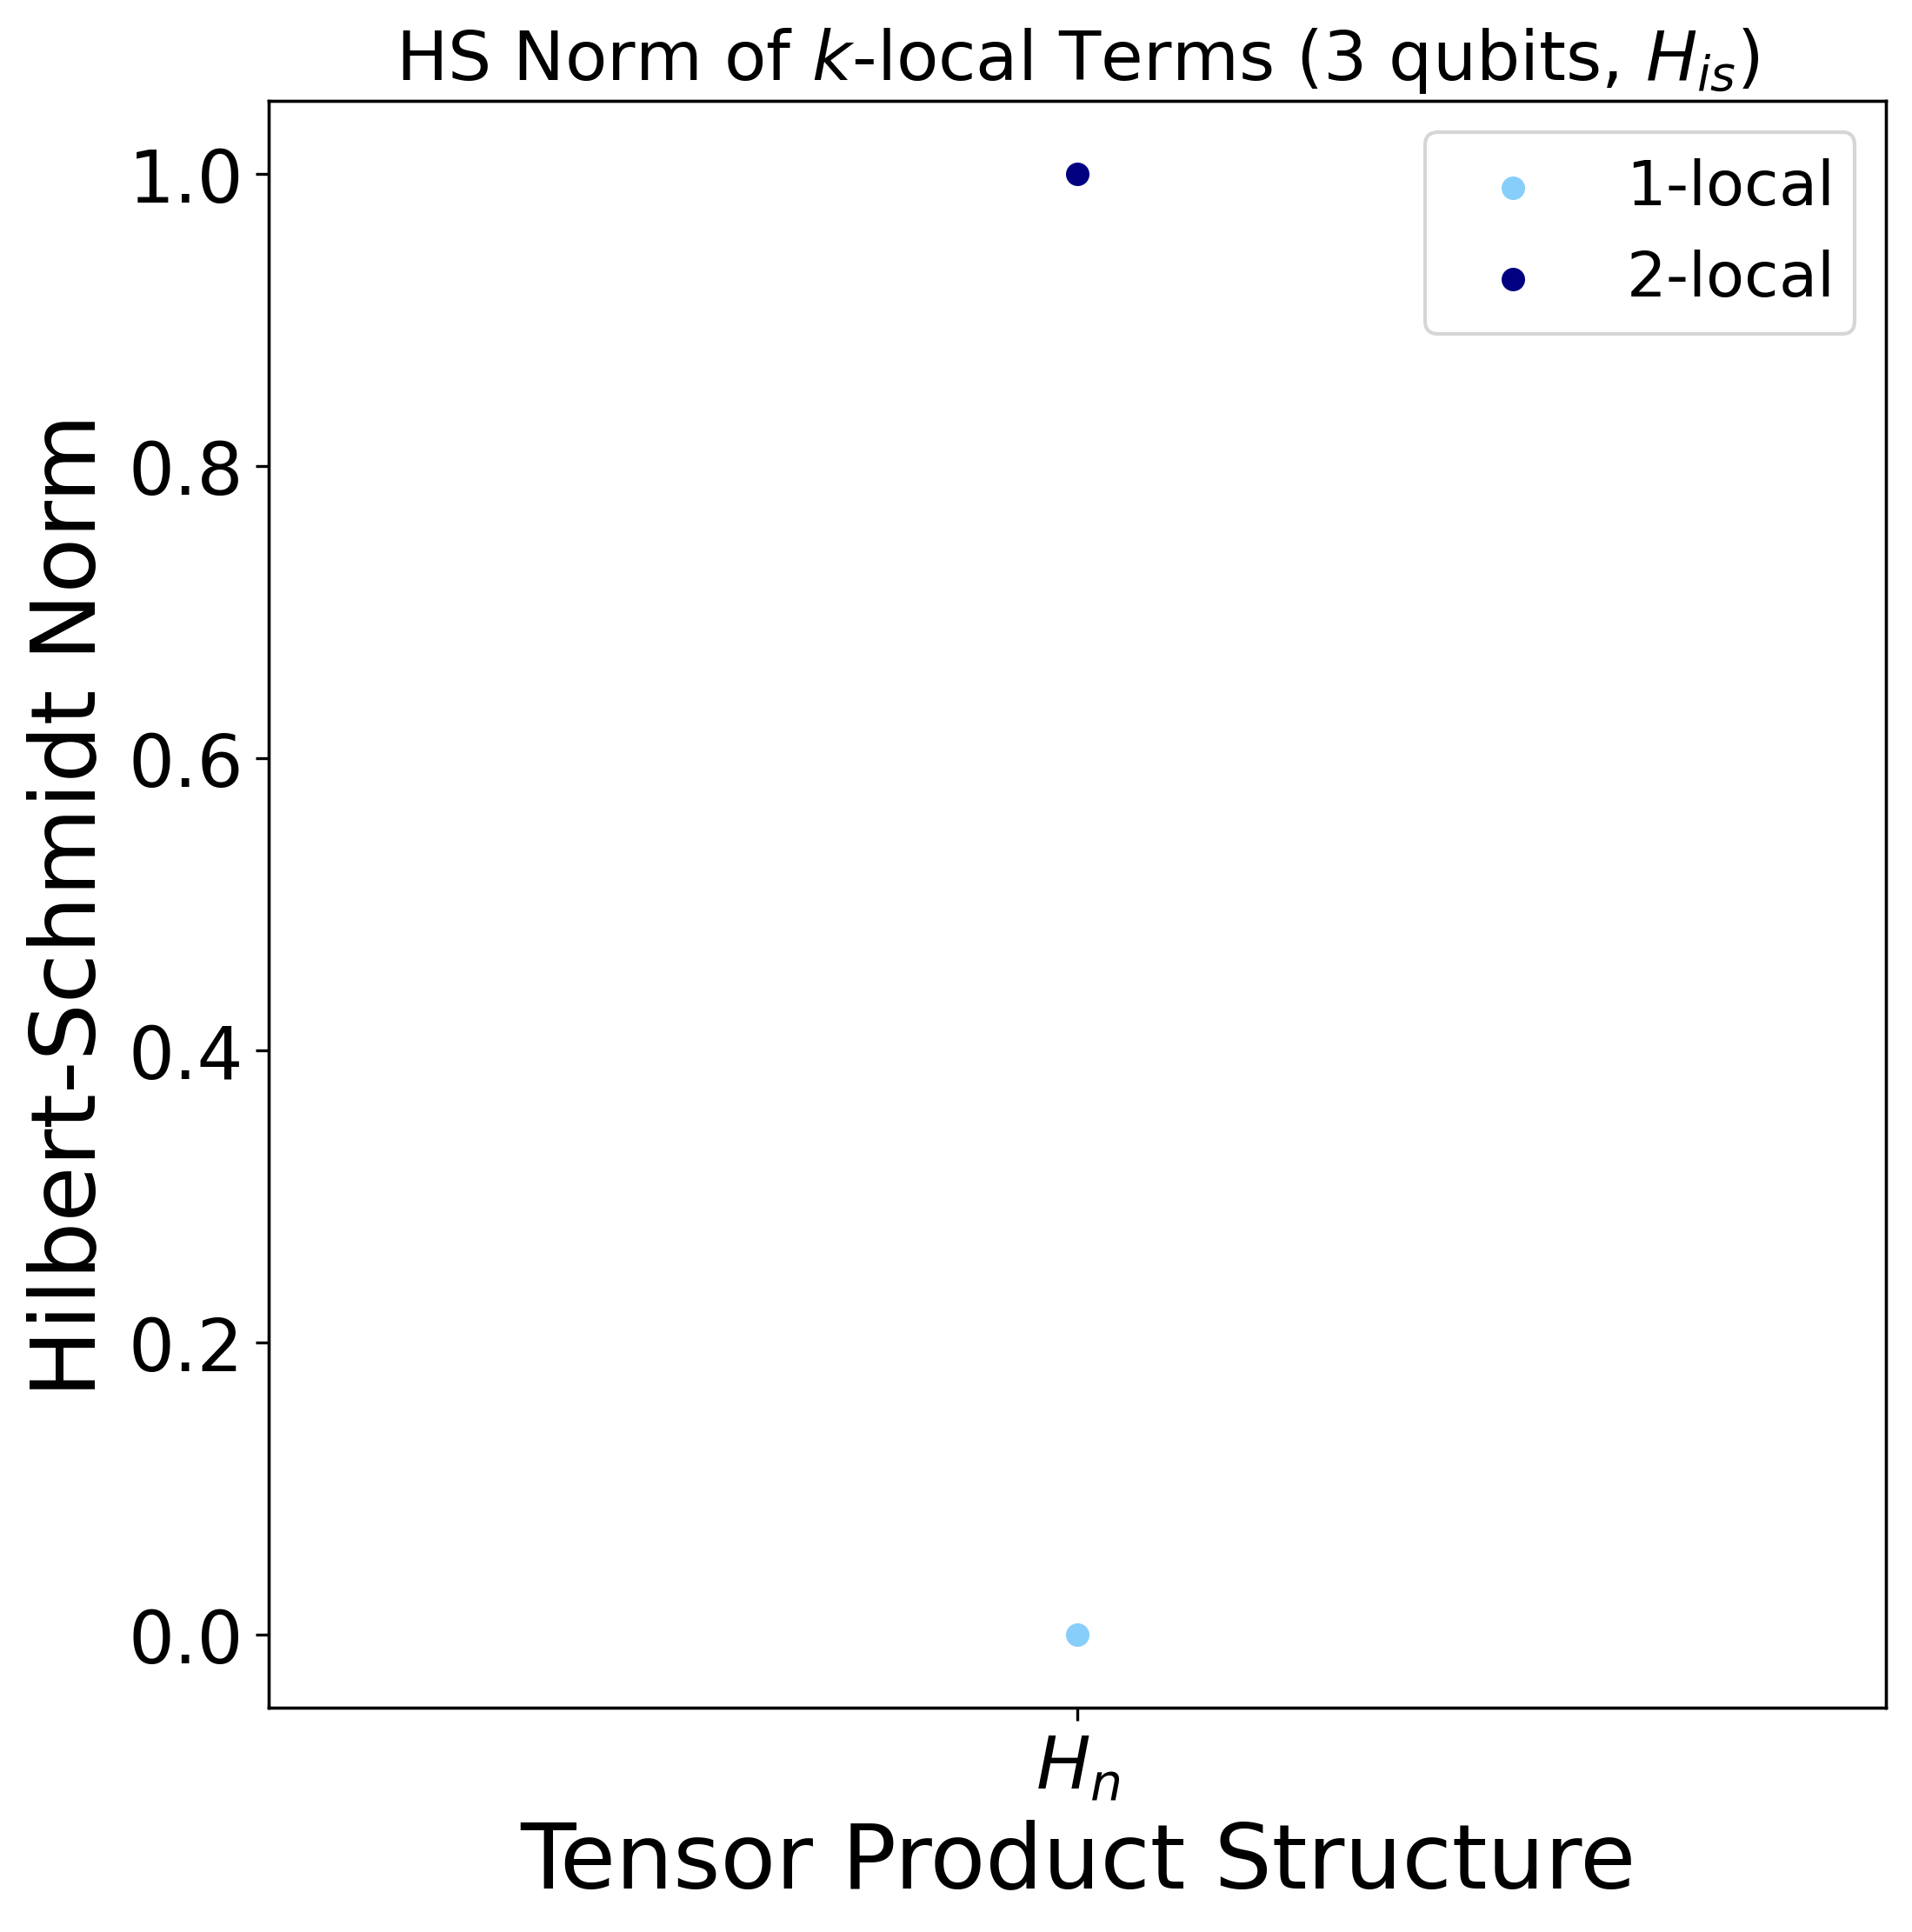

In [ ]:
# Setting up axes and labels
fig1, ax1 = plt.subplots(figsize=(8, 8), dpi = 300)
ax2 = ax1.twinx()
#ax1.set_ylim(bottom=y_lb, top=yub)
ax1.set_xlabel('Tensor Product Structure', size = u)
ax1.set_ylabel('Hilbert-Schmidt Norm', size = u)
ax1.tick_params(axis='both', which='major', labelsize=20)
#ax2.set_ylim(bottom=y_lb, top=y_ub);
ax2.set_yticks([]);
plt.title(f'HS Norm of $k$-local Terms ({n} qubits, {ham_name})', size=19)
# Plotting data
for xe, ye in zip(fiveDLinesList[0][0], meanValsT[0]):
    ax1.scatter(xe, ye, **l1M_args)
for xe, ye in zip(fiveDLinesList[0][0], meanValsT[1]):
    ax1.scatter(xe, ye, **l2M_args)
#for xe, ye in zip(fiveDLinesList[0][0], meanVals[2]):
    #ax1.scatter(xe, ye, **l3M_args)
#for xe, ye in zip(fiveDLinesList[0][0], meanVals[3]):
    #ax1.scatter(xe, ye, **l4M_args)
ax1.set_ylim(bottom=-0.05, top=1.05)
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), fontsize='xx-large', frameon=True, loc='best')

In [ ]:
# gives list of length n. the kth component tallies the number of k-local terms for the native, first, ... 
# qc-Hamiltonians
localNum = []
for i in range(n):
    kLocalNum = [0]*len(minH)
    for j in range(len(minH)):
        tσs = σs[j]
        for l in range(len(js[j])):
            if tσs[l].count('I') == i:
                kLocalNum[j] += 1
            else:
                continue
    localNum.append(kLocalNum)
localNum.reverse()

NameError: name 'minH' is not defined